In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from keras import regularizers, optimizers, layers, models
from IPython.display import display
import os
%matplotlib inline
matplotlib.style.use('ggplot')

Using TensorFlow backend.


In [2]:
# DATA PARAMETERS
DATASET_NAME = os.path.join("..", "data", "creditcard.csv")
NUMBER_OF_OK_TRANSACTIONS_IN_TRAIN_VALIDATION_DATASET = 400
N_SPLITS = 5

# NN PARAMETERS
EPOCHS = 1000
BATCH_SIZE = 50
LEARNING_RATE = 0.001
NUMBER_OF_NEURONS = 1024
REGULARIZATION_LAMBDA = 0.1

In [3]:
# Read CSV
dataset = pd.read_csv(DATASET_NAME)
dataset = dataset.drop(['Time','Amount'],axis=1)

NUMBER_OF_FEATURES = dataset.shape[1] - 1 # Minus 1 because of column: 'Class'

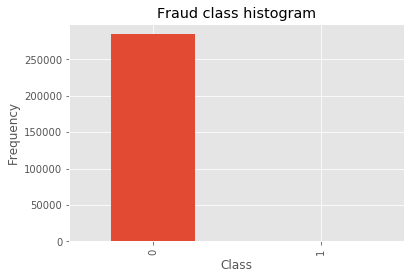

0    284315
1       492
Name: Class, dtype: int64

In [4]:
# Plot histogram for all data
count_classes = pd.value_counts(dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [5]:
# Split dataset on train_and_validation dataset and test dataset
train_and_validation, test = train_test_split(dataset, test_size = 0.2, random_state = 0)

# Convert test data to numpyarray and split them.
test = test.values
x_test = test[:,:-1]
y_test = test[:,-1:]

In [6]:
# Create balanced, under sample train and validation dataset 
fraud_indices = np.array(train_and_validation[train_and_validation.Class == 1].index)
normal_indices = np.array(train_and_validation[train_and_validation.Class == 0].index)

random_normal_indices = np.random.choice(normal_indices, NUMBER_OF_OK_TRANSACTIONS_IN_TRAIN_VALIDATION_DATASET, replace = False)
random_normal_indices = np.array(random_normal_indices)

under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])

under_sample_dataset = dataset.iloc[under_sample_indices,:]

# Shuffle train and validation dataset
under_sample_dataset = under_sample_dataset.sample(frac=1)

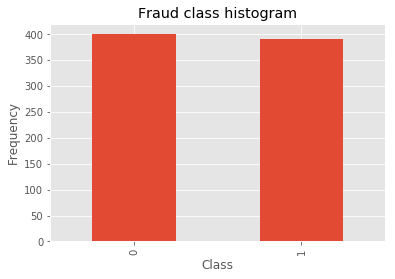

0    400
1    391
Name: Class, dtype: int64

In [7]:
# Plot histogram for training and validation dataset
count_classes = pd.value_counts(under_sample_dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [8]:
# Convert training and validation dataset to numpy array
under_sample_dataset = under_sample_dataset.values

In [9]:
# Pot loss
def show_loss(history):   
    x_axis = range(0, EPOCHS)
    fig, ax = plt.subplots()
    ax.plot(x_axis, history.history['loss'], label='train_loss')
    ax.plot(x_axis, history.history['val_loss'], label='val_loss')
    ax.legend()
    plt.ylabel('Log loss')
    plt.xlabel('epoch number')
    plt.title('loss vs epoch number')
    
    plt.show()

In [10]:
def plot_ROC(TPR_array, FPR_array):   
    plt.title('ROC')
    plt.plot(FPR_array, TPR_array, 'b')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [11]:
# NN model
import keras.backend as K

def precision(y_true, y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    TP_plus_FP = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return TP / (TP_plus_FP + K.epsilon())

def recall(y_true, y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    TP_plus_FN = K.sum(K.round(K.clip(y_true, 0, 1)))
    return TP / (TP_plus_FN + K.epsilon())

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * prec * rec / (prec + rec + K.epsilon())

def nn_model():
    model = models.Sequential()
    model.add(layers.Dense(NUMBER_OF_NEURONS,
                    input_dim=NUMBER_OF_FEATURES,
                    activation='relu',
                    kernel_regularizer=regularizers.l2(REGULARIZATION_LAMBDA)))
#     model.add(layers.Dense(NUMBER_OF_NEURONS, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    optimazier = optimizers.SGD(lr=LEARNING_RATE)
    model.compile(optimizer=optimazier,
                  loss='binary_crossentropy',
                  metrics=['accuracy', precision, recall, f1_score])
    return model

train_results = {'models': [], 'history': [], 'score': []}

kf = KFold(n_splits=N_SPLITS)
for train_index, validation_index in kf.split(under_sample_dataset):
    k_fold_train, k_fold_validation = under_sample_dataset[train_index], under_sample_dataset[validation_index]

    x_train = k_fold_train[:,:-1]
    y_train = k_fold_train[:,-1:]
        
    x_validation = k_fold_validation[:,:-1]
    y_validation = k_fold_validation[:,-1:]
    
    model = nn_model()
    history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), verbose=1, epochs=EPOCHS, batch_size=BATCH_SIZE)
    score = model.evaluate(x_validation, y_validation, batch_size=BATCH_SIZE)
    
    train_results['models'].append(model)
    train_results['history'].append(history)
    train_results['score'].append(score)

Train on 632 samples, validate on 159 samples
Epoch 1/1000
632/632 [==============================] - 0s - loss: 6.0616 - acc: 0.7801 - precision: 0.7697 - recall: 0.7973 - f1_score: 0.7706 - val_loss: 5.9090 - val_acc: 0.7925 - val_precision: 0.7462 - val_recall: 0.9170 - val_f1_score: 0.8194
Epoch 2/1000
632/632 [==============================] - 0s - loss: 5.9012 - acc: 0.8196 - precision: 0.7633 - recall: 0.9007 - f1_score: 0.8241 - val_loss: 5.8414 - val_acc: 0.8176 - val_precision: 0.7550 - val_recall: 0.9633 - val_f1_score: 0.8435
Epoch 3/1000
632/632 [==============================] - 0s - loss: 5.8492 - acc: 0.8275 - precision: 0.7675 - recall: 0.9335 - f1_score: 0.8386 - val_loss: 5.7989 - val_acc: 0.8176 - val_precision: 0.7550 - val_recall: 0.9633 - val_f1_score: 0.8435
Epoch 4/1000
632/632 [==============================] - 0s - loss: 5.8105 - acc: 0.8275 - precision: 0.7697 - recall: 0.9336 - f1_score: 0.8401 - val_loss: 5.7625 - val_acc: 0.8239 - val_precision: 0.7614 - 

632/632 [==============================] - 0s - loss: 4.9744 - acc: 0.9320 - precision: 0.9643 - recall: 0.8955 - f1_score: 0.9276 - val_loss: 4.9336 - val_acc: 0.9623 - val_precision: 0.9783 - val_recall: 0.9483 - val_f1_score: 0.9626
Epoch 34/1000
632/632 [==============================] - 0s - loss: 4.9487 - acc: 0.9320 - precision: 0.9631 - recall: 0.8923 - f1_score: 0.9245 - val_loss: 4.9081 - val_acc: 0.9560 - val_precision: 0.9779 - val_recall: 0.9379 - val_f1_score: 0.9571
Epoch 35/1000
632/632 [==============================] - 0s - loss: 4.9233 - acc: 0.9320 - precision: 0.9618 - recall: 0.8908 - f1_score: 0.9237 - val_loss: 4.8828 - val_acc: 0.9560 - val_precision: 0.9779 - val_recall: 0.9379 - val_f1_score: 0.9571
Epoch 36/1000
632/632 [==============================] - 0s - loss: 4.8980 - acc: 0.9335 - precision: 0.9684 - recall: 0.8932 - f1_score: 0.9283 - val_loss: 4.8576 - val_acc: 0.9560 - val_precision: 0.9779 - val_recall: 0.9379 - val_f1_score: 0.9571
Epoch 37/1000


632/632 [==============================] - 0s - loss: 4.2279 - acc: 0.9304 - precision: 0.9803 - recall: 0.8785 - f1_score: 0.9253 - val_loss: 4.1908 - val_acc: 0.9560 - val_precision: 0.9888 - val_recall: 0.9274 - val_f1_score: 0.9565
Epoch 66/1000
632/632 [==============================] - 0s - loss: 4.2068 - acc: 0.9304 - precision: 0.9786 - recall: 0.8810 - f1_score: 0.9259 - val_loss: 4.1698 - val_acc: 0.9560 - val_precision: 0.9888 - val_recall: 0.9274 - val_f1_score: 0.9565
Epoch 67/1000
632/632 [==============================] - 0s - loss: 4.1857 - acc: 0.9304 - precision: 0.9780 - recall: 0.8753 - f1_score: 0.9230 - val_loss: 4.1489 - val_acc: 0.9560 - val_precision: 0.9888 - val_recall: 0.9274 - val_f1_score: 0.9565
Epoch 68/1000
632/632 [==============================] - 0s - loss: 4.1649 - acc: 0.9304 - precision: 0.9796 - recall: 0.8752 - f1_score: 0.9236 - val_loss: 4.1281 - val_acc: 0.9560 - val_precision: 0.9888 - val_recall: 0.9274 - val_f1_score: 0.9565
Epoch 69/1000


632/632 [==============================] - 0s - loss: 3.6076 - acc: 0.9304 - precision: 0.9795 - recall: 0.8756 - f1_score: 0.9234 - val_loss: 3.5731 - val_acc: 0.9497 - val_precision: 0.9888 - val_recall: 0.9169 - val_f1_score: 0.9506
Epoch 98/1000
632/632 [==============================] - 0s - loss: 3.5899 - acc: 0.9304 - precision: 0.9785 - recall: 0.8768 - f1_score: 0.9235 - val_loss: 3.5555 - val_acc: 0.9497 - val_precision: 0.9888 - val_recall: 0.9169 - val_f1_score: 0.9506
Epoch 99/1000
632/632 [==============================] - 0s - loss: 3.5724 - acc: 0.9304 - precision: 0.9775 - recall: 0.8738 - f1_score: 0.9218 - val_loss: 3.5380 - val_acc: 0.9497 - val_precision: 0.9888 - val_recall: 0.9169 - val_f1_score: 0.9506
Epoch 100/1000
632/632 [==============================] - 0s - loss: 3.5549 - acc: 0.9304 - precision: 0.9799 - recall: 0.8771 - f1_score: 0.9239 - val_loss: 3.5206 - val_acc: 0.9497 - val_precision: 0.9888 - val_recall: 0.9169 - val_f1_score: 0.9506
Epoch 101/100

632/632 [==============================] - 0s - loss: 3.0872 - acc: 0.9335 - precision: 0.9851 - recall: 0.8733 - f1_score: 0.9232 - val_loss: 3.0549 - val_acc: 0.9497 - val_precision: 0.9888 - val_recall: 0.9169 - val_f1_score: 0.9506
Epoch 130/1000
632/632 [==============================] - 0s - loss: 3.0723 - acc: 0.9335 - precision: 0.9864 - recall: 0.8772 - f1_score: 0.9274 - val_loss: 3.0401 - val_acc: 0.9497 - val_precision: 0.9888 - val_recall: 0.9169 - val_f1_score: 0.9506
Epoch 131/1000
632/632 [==============================] - 0s - loss: 3.0575 - acc: 0.9335 - precision: 0.9863 - recall: 0.8783 - f1_score: 0.9266 - val_loss: 3.0254 - val_acc: 0.9497 - val_precision: 0.9888 - val_recall: 0.9169 - val_f1_score: 0.9506
Epoch 132/1000
632/632 [==============================] - 0s - loss: 3.0428 - acc: 0.9335 - precision: 0.9819 - recall: 0.8718 - f1_score: 0.9227 - val_loss: 3.0107 - val_acc: 0.9497 - val_precision: 0.9888 - val_recall: 0.9169 - val_f1_score: 0.9506
Epoch 133/1

632/632 [==============================] - 0s - loss: 2.6487 - acc: 0.9351 - precision: 0.9883 - recall: 0.8720 - f1_score: 0.9255 - val_loss: 2.6183 - val_acc: 0.9497 - val_precision: 0.9888 - val_recall: 0.9169 - val_f1_score: 0.9506
Epoch 162/1000
632/632 [==============================] - 0s - loss: 2.6362 - acc: 0.9351 - precision: 0.9899 - recall: 0.8733 - f1_score: 0.9258 - val_loss: 2.6058 - val_acc: 0.9497 - val_precision: 0.9888 - val_recall: 0.9169 - val_f1_score: 0.9506
Epoch 163/1000
632/632 [==============================] - 0s - loss: 2.6237 - acc: 0.9351 - precision: 0.9879 - recall: 0.8804 - f1_score: 0.9294 - val_loss: 2.5934 - val_acc: 0.9497 - val_precision: 0.9888 - val_recall: 0.9169 - val_f1_score: 0.9506
Epoch 164/1000
632/632 [==============================] - 0s - loss: 2.6113 - acc: 0.9351 - precision: 0.9883 - recall: 0.8752 - f1_score: 0.9272 - val_loss: 2.5811 - val_acc: 0.9497 - val_precision: 0.9888 - val_recall: 0.9169 - val_f1_score: 0.9506
Epoch 165/1

632/632 [==============================] - 0s - loss: 2.2785 - acc: 0.9351 - precision: 0.9886 - recall: 0.8756 - f1_score: 0.9271 - val_loss: 2.2497 - val_acc: 0.9497 - val_precision: 0.9888 - val_recall: 0.9169 - val_f1_score: 0.9506
Epoch 194/1000
632/632 [==============================] - 0s - loss: 2.2679 - acc: 0.9351 - precision: 0.9898 - recall: 0.8827 - f1_score: 0.9318 - val_loss: 2.2392 - val_acc: 0.9497 - val_precision: 0.9888 - val_recall: 0.9169 - val_f1_score: 0.9506
Epoch 195/1000
632/632 [==============================] - 0s - loss: 2.2573 - acc: 0.9351 - precision: 0.9888 - recall: 0.8778 - f1_score: 0.9282 - val_loss: 2.2287 - val_acc: 0.9497 - val_precision: 0.9888 - val_recall: 0.9169 - val_f1_score: 0.9506
Epoch 196/1000
632/632 [==============================] - 0s - loss: 2.2468 - acc: 0.9351 - precision: 0.9877 - recall: 0.8743 - f1_score: 0.9251 - val_loss: 2.2182 - val_acc: 0.9497 - val_precision: 0.9888 - val_recall: 0.9169 - val_f1_score: 0.9506
Epoch 197/1

632/632 [==============================] - 0s - loss: 1.9654 - acc: 0.9351 - precision: 0.9899 - recall: 0.8769 - f1_score: 0.9294 - val_loss: 1.9381 - val_acc: 0.9560 - val_precision: 0.9888 - val_recall: 0.9274 - val_f1_score: 0.9565
Epoch 226/1000
632/632 [==============================] - 0s - loss: 1.9564 - acc: 0.9351 - precision: 0.9889 - recall: 0.8756 - f1_score: 0.9282 - val_loss: 1.9292 - val_acc: 0.9560 - val_precision: 0.9888 - val_recall: 0.9274 - val_f1_score: 0.9565
Epoch 227/1000
632/632 [==============================] - 0s - loss: 1.9475 - acc: 0.9351 - precision: 0.9902 - recall: 0.8766 - f1_score: 0.9279 - val_loss: 1.9203 - val_acc: 0.9560 - val_precision: 0.9888 - val_recall: 0.9274 - val_f1_score: 0.9565
Epoch 228/1000
632/632 [==============================] - 0s - loss: 1.9386 - acc: 0.9351 - precision: 0.9898 - recall: 0.8773 - f1_score: 0.9287 - val_loss: 1.9115 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9379 - val_f1_score: 0.9622
Epoch 229/1

632/632 [==============================] - 0s - loss: 1.7004 - acc: 0.9351 - precision: 0.9884 - recall: 0.8759 - f1_score: 0.9281 - val_loss: 1.6745 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9379 - val_f1_score: 0.9622
Epoch 258/1000
632/632 [==============================] - 0s - loss: 1.6928 - acc: 0.9351 - precision: 0.9895 - recall: 0.8766 - f1_score: 0.9284 - val_loss: 1.6669 - val_acc: 0.9686 - val_precision: 0.9888 - val_recall: 0.9528 - val_f1_score: 0.9703
Epoch 259/1000
632/632 [==============================] - 0s - loss: 1.6852 - acc: 0.9351 - precision: 0.9892 - recall: 0.8771 - f1_score: 0.9283 - val_loss: 1.6594 - val_acc: 0.9686 - val_precision: 0.9888 - val_recall: 0.9528 - val_f1_score: 0.9703
Epoch 260/1000
632/632 [==============================] - 0s - loss: 1.6777 - acc: 0.9351 - precision: 0.9895 - recall: 0.8755 - f1_score: 0.9283 - val_loss: 1.6520 - val_acc: 0.9686 - val_precision: 0.9888 - val_recall: 0.9528 - val_f1_score: 0.9703
Epoch 261/1

632/632 [==============================] - 0s - loss: 1.4759 - acc: 0.9367 - precision: 0.9896 - recall: 0.8827 - f1_score: 0.9314 - val_loss: 1.4512 - val_acc: 0.9686 - val_precision: 0.9888 - val_recall: 0.9528 - val_f1_score: 0.9703
Epoch 290/1000
632/632 [==============================] - 0s - loss: 1.4695 - acc: 0.9367 - precision: 0.9882 - recall: 0.8788 - f1_score: 0.9288 - val_loss: 1.4448 - val_acc: 0.9686 - val_precision: 0.9888 - val_recall: 0.9528 - val_f1_score: 0.9703
Epoch 291/1000
632/632 [==============================] - 0s - loss: 1.4631 - acc: 0.9367 - precision: 0.9903 - recall: 0.8803 - f1_score: 0.9307 - val_loss: 1.4385 - val_acc: 0.9686 - val_precision: 0.9888 - val_recall: 0.9528 - val_f1_score: 0.9703
Epoch 292/1000
632/632 [==============================] - 0s - loss: 1.4567 - acc: 0.9367 - precision: 0.9919 - recall: 0.8762 - f1_score: 0.9292 - val_loss: 1.4321 - val_acc: 0.9686 - val_precision: 0.9888 - val_recall: 0.9528 - val_f1_score: 0.9703
Epoch 293/1

632/632 [==============================] - 0s - loss: 1.2857 - acc: 0.9367 - precision: 0.9890 - recall: 0.8795 - f1_score: 0.9297 - val_loss: 1.2620 - val_acc: 0.9686 - val_precision: 0.9888 - val_recall: 0.9528 - val_f1_score: 0.9703
Epoch 322/1000
632/632 [==============================] - 0s - loss: 1.2802 - acc: 0.9367 - precision: 0.9866 - recall: 0.8810 - f1_score: 0.9300 - val_loss: 1.2565 - val_acc: 0.9686 - val_precision: 0.9888 - val_recall: 0.9528 - val_f1_score: 0.9703
Epoch 323/1000
632/632 [==============================] - 0s - loss: 1.2748 - acc: 0.9367 - precision: 0.9877 - recall: 0.8786 - f1_score: 0.9284 - val_loss: 1.2511 - val_acc: 0.9686 - val_precision: 0.9888 - val_recall: 0.9528 - val_f1_score: 0.9703
Epoch 324/1000
632/632 [==============================] - 0s - loss: 1.2694 - acc: 0.9367 - precision: 0.9905 - recall: 0.8817 - f1_score: 0.9319 - val_loss: 1.2458 - val_acc: 0.9686 - val_precision: 0.9888 - val_recall: 0.9528 - val_f1_score: 0.9703
Epoch 325/1

632/632 [==============================] - 0s - loss: 1.1243 - acc: 0.9367 - precision: 0.9904 - recall: 0.8802 - f1_score: 0.9314 - val_loss: 1.1015 - val_acc: 0.9686 - val_precision: 0.9888 - val_recall: 0.9528 - val_f1_score: 0.9703
Epoch 354/1000
632/632 [==============================] - 0s - loss: 1.1197 - acc: 0.9367 - precision: 0.9905 - recall: 0.8764 - f1_score: 0.9284 - val_loss: 1.0969 - val_acc: 0.9686 - val_precision: 0.9888 - val_recall: 0.9528 - val_f1_score: 0.9703
Epoch 355/1000
632/632 [==============================] - 0s - loss: 1.1151 - acc: 0.9367 - precision: 0.9899 - recall: 0.8786 - f1_score: 0.9290 - val_loss: 1.0923 - val_acc: 0.9686 - val_precision: 0.9888 - val_recall: 0.9528 - val_f1_score: 0.9703
Epoch 356/1000
632/632 [==============================] - 0s - loss: 1.1105 - acc: 0.9367 - precision: 0.9907 - recall: 0.8813 - f1_score: 0.9316 - val_loss: 1.0878 - val_acc: 0.9686 - val_precision: 0.9888 - val_recall: 0.9528 - val_f1_score: 0.9703
Epoch 357/1

632/632 [==============================] - 0s - loss: 0.9874 - acc: 0.9367 - precision: 0.9887 - recall: 0.8770 - f1_score: 0.9283 - val_loss: 0.9654 - val_acc: 0.9686 - val_precision: 0.9888 - val_recall: 0.9528 - val_f1_score: 0.9703
Epoch 386/1000
632/632 [==============================] - 0s - loss: 0.9835 - acc: 0.9367 - precision: 0.9880 - recall: 0.8802 - f1_score: 0.9302 - val_loss: 0.9615 - val_acc: 0.9686 - val_precision: 0.9888 - val_recall: 0.9528 - val_f1_score: 0.9703
Epoch 387/1000
632/632 [==============================] - 0s - loss: 0.9796 - acc: 0.9367 - precision: 0.9886 - recall: 0.8799 - f1_score: 0.9301 - val_loss: 0.9576 - val_acc: 0.9686 - val_precision: 0.9888 - val_recall: 0.9528 - val_f1_score: 0.9703
Epoch 388/1000
632/632 [==============================] - 0s - loss: 0.9757 - acc: 0.9367 - precision: 0.9886 - recall: 0.8789 - f1_score: 0.9294 - val_loss: 0.9537 - val_acc: 0.9686 - val_precision: 0.9888 - val_recall: 0.9528 - val_f1_score: 0.9703
Epoch 389/1

632/632 [==============================] - 0s - loss: 0.8711 - acc: 0.9383 - precision: 0.9911 - recall: 0.8920 - f1_score: 0.9368 - val_loss: 0.8498 - val_acc: 0.9686 - val_precision: 0.9888 - val_recall: 0.9528 - val_f1_score: 0.9703
Epoch 418/1000
632/632 [==============================] - 0s - loss: 0.8678 - acc: 0.9383 - precision: 0.9892 - recall: 0.8844 - f1_score: 0.9328 - val_loss: 0.8465 - val_acc: 0.9686 - val_precision: 0.9888 - val_recall: 0.9528 - val_f1_score: 0.9703
Epoch 419/1000
632/632 [==============================] - 0s - loss: 0.8644 - acc: 0.9383 - precision: 0.9898 - recall: 0.8795 - f1_score: 0.9303 - val_loss: 0.8432 - val_acc: 0.9686 - val_precision: 0.9888 - val_recall: 0.9528 - val_f1_score: 0.9703
Epoch 420/1000
632/632 [==============================] - 0s - loss: 0.8611 - acc: 0.9383 - precision: 0.9877 - recall: 0.8820 - f1_score: 0.9303 - val_loss: 0.8399 - val_acc: 0.9686 - val_precision: 0.9888 - val_recall: 0.9528 - val_f1_score: 0.9703
Epoch 421/1

632/632 [==============================] - 0s - loss: 0.7723 - acc: 0.9383 - precision: 0.9892 - recall: 0.8806 - f1_score: 0.9308 - val_loss: 0.7516 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 450/1000
632/632 [==============================] - 0s - loss: 0.7694 - acc: 0.9383 - precision: 0.9895 - recall: 0.8814 - f1_score: 0.9319 - val_loss: 0.7488 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 451/1000
632/632 [==============================] - 0s - loss: 0.7666 - acc: 0.9383 - precision: 0.9897 - recall: 0.8839 - f1_score: 0.9330 - val_loss: 0.7460 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 452/1000
632/632 [==============================] - 0s - loss: 0.7638 - acc: 0.9383 - precision: 0.9904 - recall: 0.8830 - f1_score: 0.9325 - val_loss: 0.7432 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 453/1

632/632 [==============================] - 0s - loss: 0.6882 - acc: 0.9383 - precision: 0.9893 - recall: 0.8853 - f1_score: 0.9333 - val_loss: 0.6681 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 482/1000
632/632 [==============================] - 0s - loss: 0.6857 - acc: 0.9383 - precision: 0.9893 - recall: 0.8791 - f1_score: 0.9295 - val_loss: 0.6657 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 483/1000
632/632 [==============================] - 0s - loss: 0.6833 - acc: 0.9383 - precision: 0.9885 - recall: 0.8857 - f1_score: 0.9333 - val_loss: 0.6633 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 484/1000
632/632 [==============================] - 0s - loss: 0.6809 - acc: 0.9383 - precision: 0.9901 - recall: 0.8825 - f1_score: 0.9323 - val_loss: 0.6609 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 485/1

632/632 [==============================] - 0s - loss: 0.6166 - acc: 0.9383 - precision: 0.9896 - recall: 0.8784 - f1_score: 0.9283 - val_loss: 0.5970 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 514/1000
632/632 [==============================] - 0s - loss: 0.6145 - acc: 0.9383 - precision: 0.9843 - recall: 0.8778 - f1_score: 0.9266 - val_loss: 0.5949 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 515/1000
632/632 [==============================] - 0s - loss: 0.6125 - acc: 0.9383 - precision: 0.9892 - recall: 0.8820 - f1_score: 0.9319 - val_loss: 0.5929 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 516/1000
632/632 [==============================] - 0s - loss: 0.6104 - acc: 0.9383 - precision: 0.9893 - recall: 0.8794 - f1_score: 0.9290 - val_loss: 0.5909 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 517/1

632/632 [==============================] - 0s - loss: 0.5555 - acc: 0.9383 - precision: 0.9882 - recall: 0.8838 - f1_score: 0.9327 - val_loss: 0.5364 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 546/1000
632/632 [==============================] - 0s - loss: 0.5538 - acc: 0.9383 - precision: 0.9886 - recall: 0.8803 - f1_score: 0.9300 - val_loss: 0.5347 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 547/1000
632/632 [==============================] - 0s - loss: 0.5520 - acc: 0.9383 - precision: 0.9895 - recall: 0.8840 - f1_score: 0.9323 - val_loss: 0.5329 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 548/1000
632/632 [==============================] - 0s - loss: 0.5503 - acc: 0.9383 - precision: 0.9895 - recall: 0.8770 - f1_score: 0.9285 - val_loss: 0.5312 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 549/1

632/632 [==============================] - 0s - loss: 0.5035 - acc: 0.9383 - precision: 0.9883 - recall: 0.8834 - f1_score: 0.9319 - val_loss: 0.4848 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 578/1000
632/632 [==============================] - 0s - loss: 0.5020 - acc: 0.9383 - precision: 0.9893 - recall: 0.8789 - f1_score: 0.9295 - val_loss: 0.4833 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 579/1000
632/632 [==============================] - 0s - loss: 0.5005 - acc: 0.9383 - precision: 0.9881 - recall: 0.8824 - f1_score: 0.9311 - val_loss: 0.4818 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 580/1000
632/632 [==============================] - 0s - loss: 0.4990 - acc: 0.9383 - precision: 0.9903 - recall: 0.8843 - f1_score: 0.9335 - val_loss: 0.4803 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 581/1

632/632 [==============================] - 0s - loss: 0.4590 - acc: 0.9383 - precision: 0.9892 - recall: 0.8865 - f1_score: 0.9338 - val_loss: 0.4407 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 610/1000
632/632 [==============================] - 0s - loss: 0.4577 - acc: 0.9383 - precision: 0.9894 - recall: 0.8824 - f1_score: 0.9317 - val_loss: 0.4394 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 611/1000
632/632 [==============================] - 0s - loss: 0.4564 - acc: 0.9383 - precision: 0.9887 - recall: 0.8777 - f1_score: 0.9278 - val_loss: 0.4381 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 612/1000
632/632 [==============================] - 0s - loss: 0.4552 - acc: 0.9383 - precision: 0.9888 - recall: 0.8864 - f1_score: 0.9331 - val_loss: 0.4369 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 613/1

632/632 [==============================] - 0s - loss: 0.4210 - acc: 0.9383 - precision: 0.9891 - recall: 0.8828 - f1_score: 0.9316 - val_loss: 0.4030 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 642/1000
632/632 [==============================] - 0s - loss: 0.4199 - acc: 0.9383 - precision: 0.9905 - recall: 0.8851 - f1_score: 0.9338 - val_loss: 0.4019 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 643/1000
632/632 [==============================] - 0s - loss: 0.4188 - acc: 0.9383 - precision: 0.9887 - recall: 0.8788 - f1_score: 0.9289 - val_loss: 0.4008 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 644/1000
632/632 [==============================] - 0s - loss: 0.4177 - acc: 0.9383 - precision: 0.9887 - recall: 0.8834 - f1_score: 0.9320 - val_loss: 0.3997 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 645/1

632/632 [==============================] - 0s - loss: 0.3884 - acc: 0.9383 - precision: 0.9900 - recall: 0.8860 - f1_score: 0.9343 - val_loss: 0.3706 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 674/1000
632/632 [==============================] - 0s - loss: 0.3874 - acc: 0.9383 - precision: 0.9884 - recall: 0.8855 - f1_score: 0.9332 - val_loss: 0.3697 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 675/1000
632/632 [==============================] - 0s - loss: 0.3865 - acc: 0.9383 - precision: 0.9887 - recall: 0.8757 - f1_score: 0.9266 - val_loss: 0.3687 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 676/1000
632/632 [==============================] - 0s - loss: 0.3856 - acc: 0.9383 - precision: 0.9892 - recall: 0.8864 - f1_score: 0.9337 - val_loss: 0.3678 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 677/1

632/632 [==============================] - 0s - loss: 0.3604 - acc: 0.9383 - precision: 0.9891 - recall: 0.8856 - f1_score: 0.9335 - val_loss: 0.3428 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 706/1000
632/632 [==============================] - 0s - loss: 0.3596 - acc: 0.9383 - precision: 0.9892 - recall: 0.8807 - f1_score: 0.9310 - val_loss: 0.3420 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 707/1000
632/632 [==============================] - 0s - loss: 0.3588 - acc: 0.9383 - precision: 0.9899 - recall: 0.8834 - f1_score: 0.9328 - val_loss: 0.3412 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 708/1000
632/632 [==============================] - 0s - loss: 0.3580 - acc: 0.9383 - precision: 0.9895 - recall: 0.8809 - f1_score: 0.9306 - val_loss: 0.3404 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 709/1

632/632 [==============================] - 0s - loss: 0.3364 - acc: 0.9383 - precision: 0.9887 - recall: 0.8848 - f1_score: 0.9329 - val_loss: 0.3190 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 738/1000
632/632 [==============================] - 0s - loss: 0.3358 - acc: 0.9383 - precision: 0.9899 - recall: 0.8848 - f1_score: 0.9339 - val_loss: 0.3183 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 739/1000
632/632 [==============================] - 0s - loss: 0.3351 - acc: 0.9383 - precision: 0.9904 - recall: 0.8874 - f1_score: 0.9345 - val_loss: 0.3176 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 740/1000
632/632 [==============================] - 0s - loss: 0.3344 - acc: 0.9383 - precision: 0.9896 - recall: 0.8829 - f1_score: 0.9323 - val_loss: 0.3169 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 741/1

632/632 [==============================] - 0s - loss: 0.3158 - acc: 0.9383 - precision: 0.9894 - recall: 0.8831 - f1_score: 0.9299 - val_loss: 0.2985 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 770/1000
632/632 [==============================] - 0s - loss: 0.3152 - acc: 0.9383 - precision: 0.9900 - recall: 0.8847 - f1_score: 0.9321 - val_loss: 0.2979 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 771/1000
632/632 [==============================] - 0s - loss: 0.3146 - acc: 0.9383 - precision: 0.9896 - recall: 0.8825 - f1_score: 0.9312 - val_loss: 0.2973 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 772/1000
632/632 [==============================] - 0s - loss: 0.3140 - acc: 0.9383 - precision: 0.9892 - recall: 0.8829 - f1_score: 0.9305 - val_loss: 0.2967 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 773/1

632/632 [==============================] - 0s - loss: 0.2980 - acc: 0.9383 - precision: 0.9883 - recall: 0.8828 - f1_score: 0.9314 - val_loss: 0.2808 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 802/1000
632/632 [==============================] - 0s - loss: 0.2975 - acc: 0.9383 - precision: 0.9888 - recall: 0.8855 - f1_score: 0.9332 - val_loss: 0.2803 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 803/1000
632/632 [==============================] - 0s - loss: 0.2970 - acc: 0.9383 - precision: 0.9913 - recall: 0.8821 - f1_score: 0.9322 - val_loss: 0.2797 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 804/1000
632/632 [==============================] - 0s - loss: 0.2965 - acc: 0.9383 - precision: 0.9899 - recall: 0.8799 - f1_score: 0.9301 - val_loss: 0.2792 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 805/1

632/632 [==============================] - 0s - loss: 0.2826 - acc: 0.9399 - precision: 0.9918 - recall: 0.8827 - f1_score: 0.9330 - val_loss: 0.2655 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 834/1000
632/632 [==============================] - 0s - loss: 0.2822 - acc: 0.9383 - precision: 0.9897 - recall: 0.8843 - f1_score: 0.9325 - val_loss: 0.2650 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 835/1000
632/632 [==============================] - 0s - loss: 0.2817 - acc: 0.9383 - precision: 0.9899 - recall: 0.8811 - f1_score: 0.9314 - val_loss: 0.2646 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 836/1000
632/632 [==============================] - 0s - loss: 0.2813 - acc: 0.9399 - precision: 0.9924 - recall: 0.8840 - f1_score: 0.9347 - val_loss: 0.2641 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 837/1

632/632 [==============================] - 0s - loss: 0.2693 - acc: 0.9383 - precision: 0.9886 - recall: 0.8857 - f1_score: 0.9335 - val_loss: 0.2521 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 866/1000
632/632 [==============================] - 0s - loss: 0.2689 - acc: 0.9399 - precision: 0.9931 - recall: 0.8805 - f1_score: 0.9320 - val_loss: 0.2517 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 867/1000
632/632 [==============================] - 0s - loss: 0.2685 - acc: 0.9383 - precision: 0.9887 - recall: 0.8849 - f1_score: 0.9320 - val_loss: 0.2514 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 868/1000
632/632 [==============================] - 0s - loss: 0.2682 - acc: 0.9383 - precision: 0.9901 - recall: 0.8852 - f1_score: 0.9339 - val_loss: 0.2510 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 869/1

632/632 [==============================] - 0s - loss: 0.2578 - acc: 0.9383 - precision: 0.9887 - recall: 0.8842 - f1_score: 0.9325 - val_loss: 0.2407 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 898/1000
632/632 [==============================] - 0s - loss: 0.2574 - acc: 0.9383 - precision: 0.9871 - recall: 0.8831 - f1_score: 0.9316 - val_loss: 0.2403 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 899/1000
632/632 [==============================] - 0s - loss: 0.2571 - acc: 0.9383 - precision: 0.9882 - recall: 0.8854 - f1_score: 0.9325 - val_loss: 0.2400 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 900/1000
632/632 [==============================] - 0s - loss: 0.2568 - acc: 0.9399 - precision: 0.9921 - recall: 0.8854 - f1_score: 0.9349 - val_loss: 0.2397 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 901/1

632/632 [==============================] - 0s - loss: 0.2478 - acc: 0.9383 - precision: 0.9910 - recall: 0.8765 - f1_score: 0.9274 - val_loss: 0.2306 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 930/1000
632/632 [==============================] - 0s - loss: 0.2475 - acc: 0.9383 - precision: 0.9896 - recall: 0.8836 - f1_score: 0.9325 - val_loss: 0.2303 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 931/1000
632/632 [==============================] - ETA: 0s - loss: 0.3126 - acc: 0.9000 - precision: 1.0000 - recall: 0.7500 - f1_score: 0.857 - 0s - loss: 0.2472 - acc: 0.9383 - precision: 0.9898 - recall: 0.8816 - f1_score: 0.9303 - val_loss: 0.2300 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 932/1000
632/632 [==============================] - ETA: 0s - loss: 0.2228 - acc: 0.9600 - precision: 1.0000 - recall: 0.9048 - f1_score: 0.950 - 0s - loss: 0.246

632/632 [==============================] - 0s - loss: 0.2393 - acc: 0.9399 - precision: 0.9883 - recall: 0.8882 - f1_score: 0.9349 - val_loss: 0.2222 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 961/1000
632/632 [==============================] - 0s - loss: 0.2391 - acc: 0.9399 - precision: 0.9901 - recall: 0.8879 - f1_score: 0.9349 - val_loss: 0.2220 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 962/1000
632/632 [==============================] - 0s - loss: 0.2388 - acc: 0.9399 - precision: 0.9896 - recall: 0.8895 - f1_score: 0.9354 - val_loss: 0.2217 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 963/1000
632/632 [==============================] - 0s - loss: 0.2386 - acc: 0.9383 - precision: 0.9895 - recall: 0.8827 - f1_score: 0.9319 - val_loss: 0.2215 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 964/1

632/632 [==============================] - 0s - loss: 0.2317 - acc: 0.9399 - precision: 0.9889 - recall: 0.8876 - f1_score: 0.9337 - val_loss: 0.2146 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 993/1000
632/632 [==============================] - 0s - loss: 0.2315 - acc: 0.9399 - precision: 0.9906 - recall: 0.8847 - f1_score: 0.9316 - val_loss: 0.2144 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 994/1000
632/632 [==============================] - 0s - loss: 0.2313 - acc: 0.9399 - precision: 0.9884 - recall: 0.8838 - f1_score: 0.9306 - val_loss: 0.2142 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 995/1000
632/632 [==============================] - 0s - loss: 0.2311 - acc: 0.9399 - precision: 0.9884 - recall: 0.8817 - f1_score: 0.9311 - val_loss: 0.2140 - val_acc: 0.9623 - val_precision: 0.9888 - val_recall: 0.9423 - val_f1_score: 0.9645
Epoch 996/1

633/633 [==============================] - 0s - loss: 5.2336 - acc: 0.8894 - precision: 0.8461 - recall: 0.9685 - f1_score: 0.9013 - val_loss: 5.2859 - val_acc: 0.8608 - val_precision: 0.7589 - val_recall: 0.9397 - val_f1_score: 0.8391
Epoch 25/1000
633/633 [==============================] - 0s - loss: 5.2058 - acc: 0.8973 - precision: 0.8538 - recall: 0.9667 - f1_score: 0.9056 - val_loss: 5.2576 - val_acc: 0.8734 - val_precision: 0.7852 - val_recall: 0.9397 - val_f1_score: 0.8555
Epoch 26/1000
633/633 [==============================] - 0s - loss: 5.1781 - acc: 0.9021 - precision: 0.8628 - recall: 0.9685 - f1_score: 0.9096 - val_loss: 5.2295 - val_acc: 0.8924 - val_precision: 0.8208 - val_recall: 0.9397 - val_f1_score: 0.8761
Epoch 27/1000
633/633 [==============================] - 0s - loss: 5.1506 - acc: 0.9100 - precision: 0.8771 - recall: 0.9676 - f1_score: 0.9191 - val_loss: 5.2016 - val_acc: 0.9051 - val_precision: 0.8491 - val_recall: 0.9397 - val_f1_score: 0.8918
Epoch 28/1000


633/633 [==============================] - 0s - loss: 4.4310 - acc: 0.9494 - precision: 0.9789 - recall: 0.9172 - f1_score: 0.9465 - val_loss: 4.4728 - val_acc: 0.9494 - val_precision: 0.9824 - val_recall: 0.8885 - val_f1_score: 0.9327
Epoch 57/1000
633/633 [==============================] - 0s - loss: 4.4085 - acc: 0.9463 - precision: 0.9800 - recall: 0.9142 - f1_score: 0.9453 - val_loss: 4.4501 - val_acc: 0.9494 - val_precision: 0.9824 - val_recall: 0.8885 - val_f1_score: 0.9327
Epoch 58/1000
633/633 [==============================] - 0s - loss: 4.3861 - acc: 0.9463 - precision: 0.9810 - recall: 0.9139 - f1_score: 0.9456 - val_loss: 4.4275 - val_acc: 0.9494 - val_precision: 0.9824 - val_recall: 0.8885 - val_f1_score: 0.9327
Epoch 59/1000
633/633 [==============================] - 0s - loss: 4.3639 - acc: 0.9463 - precision: 0.9777 - recall: 0.9145 - f1_score: 0.9441 - val_loss: 4.4051 - val_acc: 0.9494 - val_precision: 0.9824 - val_recall: 0.8885 - val_f1_score: 0.9327
Epoch 60/1000


633/633 [==============================] - 0s - loss: 3.7729 - acc: 0.9400 - precision: 0.9806 - recall: 0.9024 - f1_score: 0.9382 - val_loss: 3.8102 - val_acc: 0.9430 - val_precision: 0.9814 - val_recall: 0.8734 - val_f1_score: 0.9233
Epoch 89/1000
633/633 [==============================] - 0s - loss: 3.7542 - acc: 0.9400 - precision: 0.9797 - recall: 0.9038 - f1_score: 0.9393 - val_loss: 3.7914 - val_acc: 0.9430 - val_precision: 0.9814 - val_recall: 0.8734 - val_f1_score: 0.9233
Epoch 90/1000
633/633 [==============================] - 0s - loss: 3.7356 - acc: 0.9400 - precision: 0.9803 - recall: 0.9046 - f1_score: 0.9399 - val_loss: 3.7728 - val_acc: 0.9430 - val_precision: 0.9814 - val_recall: 0.8734 - val_f1_score: 0.9233
Epoch 91/1000
633/633 [==============================] - 0s - loss: 3.7171 - acc: 0.9400 - precision: 0.9788 - recall: 0.9057 - f1_score: 0.9399 - val_loss: 3.7542 - val_acc: 0.9430 - val_precision: 0.9814 - val_recall: 0.8734 - val_f1_score: 0.9233
Epoch 92/1000


633/633 [==============================] - 0s - loss: 3.2235 - acc: 0.9368 - precision: 0.9788 - recall: 0.8941 - f1_score: 0.9326 - val_loss: 3.2592 - val_acc: 0.9367 - val_precision: 0.9802 - val_recall: 0.8583 - val_f1_score: 0.9134
Epoch 121/1000
633/633 [==============================] - 0s - loss: 3.2078 - acc: 0.9368 - precision: 0.9797 - recall: 0.8987 - f1_score: 0.9359 - val_loss: 3.2434 - val_acc: 0.9367 - val_precision: 0.9802 - val_recall: 0.8583 - val_f1_score: 0.9134
Epoch 122/1000
633/633 [==============================] - 0s - loss: 3.1922 - acc: 0.9368 - precision: 0.9785 - recall: 0.8918 - f1_score: 0.9322 - val_loss: 3.2278 - val_acc: 0.9367 - val_precision: 0.9802 - val_recall: 0.8583 - val_f1_score: 0.9134
Epoch 123/1000
633/633 [==============================] - 0s - loss: 3.1767 - acc: 0.9368 - precision: 0.9809 - recall: 0.8960 - f1_score: 0.9357 - val_loss: 3.2123 - val_acc: 0.9367 - val_precision: 0.9802 - val_recall: 0.8583 - val_f1_score: 0.9134
Epoch 124/1

633/633 [==============================] - 0s - loss: 2.7616 - acc: 0.9384 - precision: 0.9818 - recall: 0.8993 - f1_score: 0.9373 - val_loss: 2.7967 - val_acc: 0.9367 - val_precision: 0.9802 - val_recall: 0.8583 - val_f1_score: 0.9134
Epoch 153/1000
633/633 [==============================] - 0s - loss: 2.7484 - acc: 0.9384 - precision: 0.9812 - recall: 0.8998 - f1_score: 0.9385 - val_loss: 2.7835 - val_acc: 0.9367 - val_precision: 0.9802 - val_recall: 0.8583 - val_f1_score: 0.9134
Epoch 154/1000
633/633 [==============================] - 0s - loss: 2.7352 - acc: 0.9384 - precision: 0.9798 - recall: 0.8988 - f1_score: 0.9366 - val_loss: 2.7704 - val_acc: 0.9367 - val_precision: 0.9802 - val_recall: 0.8583 - val_f1_score: 0.9134
Epoch 155/1000
633/633 [==============================] - 0s - loss: 2.7222 - acc: 0.9384 - precision: 0.9784 - recall: 0.8962 - f1_score: 0.9346 - val_loss: 2.7573 - val_acc: 0.9367 - val_precision: 0.9802 - val_recall: 0.8583 - val_f1_score: 0.9134
Epoch 156/1

633/633 [==============================] - 0s - loss: 2.3720 - acc: 0.9400 - precision: 0.9814 - recall: 0.9082 - f1_score: 0.9428 - val_loss: 2.4072 - val_acc: 0.9304 - val_precision: 0.9628 - val_recall: 0.8583 - val_f1_score: 0.9066
Epoch 185/1000
633/633 [==============================] - 0s - loss: 2.3609 - acc: 0.9400 - precision: 0.9781 - recall: 0.9015 - f1_score: 0.9377 - val_loss: 2.3961 - val_acc: 0.9304 - val_precision: 0.9628 - val_recall: 0.8583 - val_f1_score: 0.9066
Epoch 186/1000
633/633 [==============================] - 0s - loss: 2.3498 - acc: 0.9400 - precision: 0.9810 - recall: 0.9023 - f1_score: 0.9390 - val_loss: 2.3850 - val_acc: 0.9304 - val_precision: 0.9628 - val_recall: 0.8583 - val_f1_score: 0.9066
Epoch 187/1000
633/633 [==============================] - 0s - loss: 2.3387 - acc: 0.9400 - precision: 0.9823 - recall: 0.9018 - f1_score: 0.9391 - val_loss: 2.3740 - val_acc: 0.9304 - val_precision: 0.9628 - val_recall: 0.8583 - val_f1_score: 0.9066
Epoch 188/1

633/633 [==============================] - 0s - loss: 2.0428 - acc: 0.9415 - precision: 0.9820 - recall: 0.9053 - f1_score: 0.9406 - val_loss: 2.0783 - val_acc: 0.9304 - val_precision: 0.9628 - val_recall: 0.8583 - val_f1_score: 0.9066
Epoch 217/1000
633/633 [==============================] - 0s - loss: 2.0334 - acc: 0.9415 - precision: 0.9861 - recall: 0.9048 - f1_score: 0.9430 - val_loss: 2.0689 - val_acc: 0.9304 - val_precision: 0.9628 - val_recall: 0.8583 - val_f1_score: 0.9066
Epoch 218/1000
633/633 [==============================] - 0s - loss: 2.0240 - acc: 0.9415 - precision: 0.9834 - recall: 0.9037 - f1_score: 0.9414 - val_loss: 2.0595 - val_acc: 0.9304 - val_precision: 0.9628 - val_recall: 0.8583 - val_f1_score: 0.9066
Epoch 219/1000
633/633 [==============================] - 0s - loss: 2.0147 - acc: 0.9415 - precision: 0.9832 - recall: 0.9015 - f1_score: 0.9394 - val_loss: 2.0502 - val_acc: 0.9304 - val_precision: 0.9628 - val_recall: 0.8583 - val_f1_score: 0.9066
Epoch 220/1

633/633 [==============================] - 0s - loss: 1.7644 - acc: 0.9415 - precision: 0.9835 - recall: 0.9054 - f1_score: 0.9422 - val_loss: 1.8001 - val_acc: 0.9304 - val_precision: 0.9628 - val_recall: 0.8583 - val_f1_score: 0.9066
Epoch 249/1000
633/633 [==============================] - 0s - loss: 1.7564 - acc: 0.9415 - precision: 0.9832 - recall: 0.9035 - f1_score: 0.9405 - val_loss: 1.7922 - val_acc: 0.9304 - val_precision: 0.9628 - val_recall: 0.8583 - val_f1_score: 0.9066
Epoch 250/1000
633/633 [==============================] - 0s - loss: 1.7485 - acc: 0.9415 - precision: 0.9836 - recall: 0.9016 - f1_score: 0.9401 - val_loss: 1.7842 - val_acc: 0.9304 - val_precision: 0.9628 - val_recall: 0.8583 - val_f1_score: 0.9066
Epoch 251/1000
633/633 [==============================] - 0s - loss: 1.7406 - acc: 0.9415 - precision: 0.9828 - recall: 0.9025 - f1_score: 0.9403 - val_loss: 1.7764 - val_acc: 0.9304 - val_precision: 0.9628 - val_recall: 0.8583 - val_f1_score: 0.9066
Epoch 252/1

633/633 [==============================] - 0s - loss: 1.5354 - acc: 0.9415 - precision: 0.9833 - recall: 0.9032 - f1_score: 0.9400 - val_loss: 1.5715 - val_acc: 0.9304 - val_precision: 0.9628 - val_recall: 0.8583 - val_f1_score: 0.9066
Epoch 280/1000
633/633 [==============================] - 0s - loss: 1.5286 - acc: 0.9415 - precision: 0.9831 - recall: 0.9074 - f1_score: 0.9420 - val_loss: 1.5647 - val_acc: 0.9304 - val_precision: 0.9628 - val_recall: 0.8583 - val_f1_score: 0.9066
Epoch 281/1000
633/633 [==============================] - 0s - loss: 1.5218 - acc: 0.9415 - precision: 0.9839 - recall: 0.9021 - f1_score: 0.9399 - val_loss: 1.5579 - val_acc: 0.9304 - val_precision: 0.9628 - val_recall: 0.8583 - val_f1_score: 0.9066
Epoch 282/1000
633/633 [==============================] - 0s - loss: 1.5151 - acc: 0.9415 - precision: 0.9812 - recall: 0.8985 - f1_score: 0.9372 - val_loss: 1.5512 - val_acc: 0.9304 - val_precision: 0.9628 - val_recall: 0.8583 - val_f1_score: 0.9066
Epoch 283/1

633/633 [==============================] - 0s - loss: 1.3346 - acc: 0.9415 - precision: 0.9830 - recall: 0.9045 - f1_score: 0.9403 - val_loss: 1.3709 - val_acc: 0.9304 - val_precision: 0.9628 - val_recall: 0.8583 - val_f1_score: 0.9066
Epoch 312/1000
633/633 [==============================] - 0s - loss: 1.3288 - acc: 0.9447 - precision: 0.9841 - recall: 0.9099 - f1_score: 0.9447 - val_loss: 1.3652 - val_acc: 0.9304 - val_precision: 0.9628 - val_recall: 0.8583 - val_f1_score: 0.9066
Epoch 313/1000
633/633 [==============================] - 0s - loss: 1.3231 - acc: 0.9431 - precision: 0.9851 - recall: 0.9067 - f1_score: 0.9432 - val_loss: 1.3594 - val_acc: 0.9304 - val_precision: 0.9628 - val_recall: 0.8583 - val_f1_score: 0.9066
Epoch 314/1000
633/633 [==============================] - 0s - loss: 1.3174 - acc: 0.9447 - precision: 0.9826 - recall: 0.9074 - f1_score: 0.9424 - val_loss: 1.3537 - val_acc: 0.9304 - val_precision: 0.9628 - val_recall: 0.8583 - val_f1_score: 0.9066
Epoch 315/1

633/633 [==============================] - 0s - loss: 1.1643 - acc: 0.9463 - precision: 0.9880 - recall: 0.9117 - f1_score: 0.9478 - val_loss: 1.2009 - val_acc: 0.9241 - val_precision: 0.9628 - val_recall: 0.8433 - val_f1_score: 0.8981
Epoch 344/1000
633/633 [==============================] - 0s - loss: 1.1594 - acc: 0.9463 - precision: 0.9870 - recall: 0.9139 - f1_score: 0.9477 - val_loss: 1.1960 - val_acc: 0.9241 - val_precision: 0.9628 - val_recall: 0.8433 - val_f1_score: 0.8981
Epoch 345/1000
633/633 [==============================] - 0s - loss: 1.1545 - acc: 0.9463 - precision: 0.9872 - recall: 0.9096 - f1_score: 0.9457 - val_loss: 1.1912 - val_acc: 0.9241 - val_precision: 0.9628 - val_recall: 0.8433 - val_f1_score: 0.8981
Epoch 346/1000
633/633 [==============================] - 0s - loss: 1.1497 - acc: 0.9463 - precision: 0.9878 - recall: 0.9109 - f1_score: 0.9469 - val_loss: 1.1864 - val_acc: 0.9241 - val_precision: 0.9628 - val_recall: 0.8433 - val_f1_score: 0.8981
Epoch 347/1

633/633 [==============================] - 0s - loss: 1.0198 - acc: 0.9447 - precision: 0.9866 - recall: 0.9042 - f1_score: 0.9423 - val_loss: 1.0567 - val_acc: 0.9241 - val_precision: 0.9628 - val_recall: 0.8433 - val_f1_score: 0.8981
Epoch 376/1000
633/633 [==============================] - 0s - loss: 1.0157 - acc: 0.9447 - precision: 0.9870 - recall: 0.9025 - f1_score: 0.9414 - val_loss: 1.0525 - val_acc: 0.9241 - val_precision: 0.9628 - val_recall: 0.8433 - val_f1_score: 0.8981
Epoch 377/1000
633/633 [==============================] - 0s - loss: 1.0115 - acc: 0.9447 - precision: 0.9867 - recall: 0.9079 - f1_score: 0.9447 - val_loss: 1.0484 - val_acc: 0.9241 - val_precision: 0.9628 - val_recall: 0.8433 - val_f1_score: 0.8981
Epoch 378/1000
633/633 [==============================] - 0s - loss: 1.0074 - acc: 0.9447 - precision: 0.9880 - recall: 0.9035 - f1_score: 0.9431 - val_loss: 1.0443 - val_acc: 0.9241 - val_precision: 0.9628 - val_recall: 0.8433 - val_f1_score: 0.8981
Epoch 379/1

633/633 [==============================] - 0s - loss: 0.8971 - acc: 0.9447 - precision: 0.9865 - recall: 0.9046 - f1_score: 0.9433 - val_loss: 0.9342 - val_acc: 0.9241 - val_precision: 0.9628 - val_recall: 0.8433 - val_f1_score: 0.8981
Epoch 408/1000
633/633 [==============================] - 0s - loss: 0.8936 - acc: 0.9447 - precision: 0.9867 - recall: 0.9049 - f1_score: 0.9431 - val_loss: 0.9307 - val_acc: 0.9241 - val_precision: 0.9628 - val_recall: 0.8433 - val_f1_score: 0.8981
Epoch 409/1000
633/633 [==============================] - 0s - loss: 0.8901 - acc: 0.9463 - precision: 0.9878 - recall: 0.9111 - f1_score: 0.9468 - val_loss: 0.9272 - val_acc: 0.9241 - val_precision: 0.9628 - val_recall: 0.8433 - val_f1_score: 0.8981
Epoch 410/1000
633/633 [==============================] - 0s - loss: 0.8866 - acc: 0.9447 - precision: 0.9860 - recall: 0.9059 - f1_score: 0.9431 - val_loss: 0.9237 - val_acc: 0.9241 - val_precision: 0.9628 - val_recall: 0.8433 - val_f1_score: 0.8981
Epoch 411/1

633/633 [==============================] - 0s - loss: 0.7929 - acc: 0.9463 - precision: 0.9874 - recall: 0.9061 - f1_score: 0.9442 - val_loss: 0.8301 - val_acc: 0.9241 - val_precision: 0.9628 - val_recall: 0.8433 - val_f1_score: 0.8981
Epoch 440/1000
633/633 [==============================] - 0s - loss: 0.7899 - acc: 0.9463 - precision: 0.9867 - recall: 0.9101 - f1_score: 0.9457 - val_loss: 0.8271 - val_acc: 0.9241 - val_precision: 0.9628 - val_recall: 0.8433 - val_f1_score: 0.8981
Epoch 441/1000
633/633 [==============================] - 0s - loss: 0.7869 - acc: 0.9463 - precision: 0.9880 - recall: 0.9088 - f1_score: 0.9455 - val_loss: 0.8241 - val_acc: 0.9241 - val_precision: 0.9628 - val_recall: 0.8433 - val_f1_score: 0.8981
Epoch 442/1000
633/633 [==============================] - 0s - loss: 0.7840 - acc: 0.9463 - precision: 0.9858 - recall: 0.9125 - f1_score: 0.9459 - val_loss: 0.8212 - val_acc: 0.9241 - val_precision: 0.9628 - val_recall: 0.8433 - val_f1_score: 0.8981
Epoch 443/1

633/633 [==============================] - 0s - loss: 0.7043 - acc: 0.9463 - precision: 0.9864 - recall: 0.9103 - f1_score: 0.9462 - val_loss: 0.7415 - val_acc: 0.9241 - val_precision: 0.9628 - val_recall: 0.8433 - val_f1_score: 0.8981
Epoch 472/1000
633/633 [==============================] - 0s - loss: 0.7017 - acc: 0.9463 - precision: 0.9884 - recall: 0.9091 - f1_score: 0.9461 - val_loss: 0.7390 - val_acc: 0.9241 - val_precision: 0.9628 - val_recall: 0.8433 - val_f1_score: 0.8981
Epoch 473/1000
633/633 [==============================] - 0s - loss: 0.6992 - acc: 0.9463 - precision: 0.9873 - recall: 0.9094 - f1_score: 0.9462 - val_loss: 0.7364 - val_acc: 0.9241 - val_precision: 0.9628 - val_recall: 0.8433 - val_f1_score: 0.8981
Epoch 474/1000
633/633 [==============================] - 0s - loss: 0.6967 - acc: 0.9463 - precision: 0.9869 - recall: 0.9127 - f1_score: 0.9471 - val_loss: 0.7339 - val_acc: 0.9241 - val_precision: 0.9628 - val_recall: 0.8433 - val_f1_score: 0.8981
Epoch 475/1

633/633 [==============================] - ETA: 0s - loss: 0.6616 - acc: 0.9400 - precision: 1.0000 - recall: 0.8571 - f1_score: 0.923 - 0s - loss: 0.6288 - acc: 0.9479 - precision: 0.9908 - recall: 0.9084 - f1_score: 0.9467 - val_loss: 0.6661 - val_acc: 0.9241 - val_precision: 0.9628 - val_recall: 0.8433 - val_f1_score: 0.8981
Epoch 504/1000
633/633 [==============================] - 0s - loss: 0.6267 - acc: 0.9479 - precision: 0.9891 - recall: 0.9105 - f1_score: 0.9472 - val_loss: 0.6639 - val_acc: 0.9241 - val_precision: 0.9628 - val_recall: 0.8433 - val_f1_score: 0.8981
Epoch 505/1000
633/633 [==============================] - 0s - loss: 0.6245 - acc: 0.9479 - precision: 0.9893 - recall: 0.9069 - f1_score: 0.9454 - val_loss: 0.6618 - val_acc: 0.9241 - val_precision: 0.9628 - val_recall: 0.8433 - val_f1_score: 0.8981
Epoch 506/1000
633/633 [==============================] - 0s - loss: 0.6224 - acc: 0.9479 - precision: 0.9900 - recall: 0.9127 - f1_score: 0.9489 - val_loss: 0.6596 - v

633/633 [==============================] - 0s - loss: 0.5646 - acc: 0.9479 - precision: 0.9902 - recall: 0.9115 - f1_score: 0.9486 - val_loss: 0.6018 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 536/1000
633/633 [==============================] - 0s - loss: 0.5627 - acc: 0.9479 - precision: 0.9894 - recall: 0.9105 - f1_score: 0.9476 - val_loss: 0.5999 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 537/1000
633/633 [==============================] - 0s - loss: 0.5609 - acc: 0.9479 - precision: 0.9900 - recall: 0.9098 - f1_score: 0.9475 - val_loss: 0.5981 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 538/1000
633/633 [==============================] - ETA: 0s - loss: 0.5895 - acc: 0.9400 - precision: 0.9524 - recall: 0.9091 - f1_score: 0.930 - 0s - loss: 0.5591 - acc: 0.9479 - precision: 0.9892 - recall: 0.9094 - f1_score: 0.9468 - val_loss: 0.5963 - v

633/633 [==============================] - 0s - loss: 0.5098 - acc: 0.9479 - precision: 0.9896 - recall: 0.9073 - f1_score: 0.9453 - val_loss: 0.5469 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 568/1000
633/633 [==============================] - 0s - loss: 0.5082 - acc: 0.9479 - precision: 0.9903 - recall: 0.9037 - f1_score: 0.9431 - val_loss: 0.5453 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 569/1000
633/633 [==============================] - 0s - loss: 0.5067 - acc: 0.9479 - precision: 0.9901 - recall: 0.9106 - f1_score: 0.9477 - val_loss: 0.5438 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 570/1000
633/633 [==============================] - 0s - loss: 0.5051 - acc: 0.9479 - precision: 0.9905 - recall: 0.9089 - f1_score: 0.9472 - val_loss: 0.5422 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 571/1

633/633 [==============================] - 0s - loss: 0.4630 - acc: 0.9479 - precision: 0.9899 - recall: 0.9060 - f1_score: 0.9455 - val_loss: 0.5000 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 600/1000
633/633 [==============================] - 0s - loss: 0.4617 - acc: 0.9479 - precision: 0.9895 - recall: 0.9120 - f1_score: 0.9480 - val_loss: 0.4987 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 601/1000
633/633 [==============================] - 0s - loss: 0.4603 - acc: 0.9479 - precision: 0.9897 - recall: 0.9107 - f1_score: 0.9482 - val_loss: 0.4973 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 602/1000
633/633 [==============================] - 0s - loss: 0.4590 - acc: 0.9479 - precision: 0.9903 - recall: 0.9101 - f1_score: 0.9473 - val_loss: 0.4960 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 603/1

633/633 [==============================] - 0s - loss: 0.4230 - acc: 0.9479 - precision: 0.9907 - recall: 0.9091 - f1_score: 0.9476 - val_loss: 0.4599 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 632/1000
633/633 [==============================] - 0s - loss: 0.4219 - acc: 0.9479 - precision: 0.9903 - recall: 0.9103 - f1_score: 0.9479 - val_loss: 0.4587 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 633/1000
633/633 [==============================] - ETA: 0s - loss: 0.3917 - acc: 0.9800 - precision: 1.0000 - recall: 0.9565 - f1_score: 0.977 - 0s - loss: 0.4207 - acc: 0.9479 - precision: 0.9902 - recall: 0.9080 - f1_score: 0.9467 - val_loss: 0.4576 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 634/1000
633/633 [==============================] - 0s - loss: 0.4196 - acc: 0.9479 - precision: 0.9892 - recall: 0.9081 - f1_score: 0.9451 - val_loss: 0.4564 - v

633/633 [==============================] - 0s - loss: 0.3888 - acc: 0.9479 - precision: 0.9903 - recall: 0.9114 - f1_score: 0.9481 - val_loss: 0.4255 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 664/1000
633/633 [==============================] - 0s - loss: 0.3878 - acc: 0.9479 - precision: 0.9902 - recall: 0.9130 - f1_score: 0.9486 - val_loss: 0.4245 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 665/1000
633/633 [==============================] - 0s - loss: 0.3869 - acc: 0.9479 - precision: 0.9908 - recall: 0.9105 - f1_score: 0.9478 - val_loss: 0.4235 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 666/1000
633/633 [==============================] - 0s - loss: 0.3859 - acc: 0.9479 - precision: 0.9909 - recall: 0.9099 - f1_score: 0.9477 - val_loss: 0.4225 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 667/1

633/633 [==============================] - 0s - loss: 0.3595 - acc: 0.9479 - precision: 0.9889 - recall: 0.9079 - f1_score: 0.9458 - val_loss: 0.3960 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 696/1000
633/633 [==============================] - 0s - loss: 0.3587 - acc: 0.9479 - precision: 0.9904 - recall: 0.9094 - f1_score: 0.9470 - val_loss: 0.3951 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 697/1000
633/633 [==============================] - 0s - loss: 0.3578 - acc: 0.9479 - precision: 0.9912 - recall: 0.9055 - f1_score: 0.9459 - val_loss: 0.3943 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 698/1000
633/633 [==============================] - 0s - loss: 0.3570 - acc: 0.9479 - precision: 0.9903 - recall: 0.9121 - f1_score: 0.9473 - val_loss: 0.3934 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 699/1

633/633 [==============================] - 0s - loss: 0.3343 - acc: 0.9479 - precision: 0.9905 - recall: 0.9097 - f1_score: 0.9477 - val_loss: 0.3706 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 728/1000
633/633 [==============================] - 0s - loss: 0.3336 - acc: 0.9479 - precision: 0.9898 - recall: 0.9089 - f1_score: 0.9472 - val_loss: 0.3699 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 729/1000
633/633 [==============================] - 0s - loss: 0.3329 - acc: 0.9479 - precision: 0.9890 - recall: 0.9102 - f1_score: 0.9470 - val_loss: 0.3691 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 730/1000
633/633 [==============================] - 0s - loss: 0.3322 - acc: 0.9479 - precision: 0.9889 - recall: 0.9090 - f1_score: 0.9466 - val_loss: 0.3684 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 731/1

633/633 [==============================] - 0s - loss: 0.3127 - acc: 0.9479 - precision: 0.9889 - recall: 0.9124 - f1_score: 0.9482 - val_loss: 0.3488 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 760/1000
633/633 [==============================] - 0s - loss: 0.3121 - acc: 0.9479 - precision: 0.9900 - recall: 0.9090 - f1_score: 0.9470 - val_loss: 0.3482 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 761/1000
633/633 [==============================] - 0s - loss: 0.3114 - acc: 0.9479 - precision: 0.9910 - recall: 0.9079 - f1_score: 0.9467 - val_loss: 0.3475 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 762/1000
633/633 [==============================] - 0s - loss: 0.3108 - acc: 0.9479 - precision: 0.9897 - recall: 0.9056 - f1_score: 0.9448 - val_loss: 0.3469 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 763/1

633/633 [==============================] - 0s - loss: 0.2941 - acc: 0.9479 - precision: 0.9905 - recall: 0.9099 - f1_score: 0.9481 - val_loss: 0.3300 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 792/1000
633/633 [==============================] - 0s - loss: 0.2935 - acc: 0.9479 - precision: 0.9898 - recall: 0.9095 - f1_score: 0.9476 - val_loss: 0.3294 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 793/1000
633/633 [==============================] - 0s - loss: 0.2930 - acc: 0.9479 - precision: 0.9909 - recall: 0.9070 - f1_score: 0.9465 - val_loss: 0.3289 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 794/1000
633/633 [==============================] - 0s - loss: 0.2925 - acc: 0.9479 - precision: 0.9908 - recall: 0.9064 - f1_score: 0.9453 - val_loss: 0.3283 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 795/1

633/633 [==============================] - 0s - loss: 0.2780 - acc: 0.9479 - precision: 0.9895 - recall: 0.9123 - f1_score: 0.9482 - val_loss: 0.3137 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 824/1000
633/633 [==============================] - 0s - loss: 0.2775 - acc: 0.9479 - precision: 0.9900 - recall: 0.9096 - f1_score: 0.9473 - val_loss: 0.3132 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 825/1000
633/633 [==============================] - 0s - loss: 0.2771 - acc: 0.9479 - precision: 0.9895 - recall: 0.9100 - f1_score: 0.9477 - val_loss: 0.3128 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 826/1000
633/633 [==============================] - 0s - loss: 0.2766 - acc: 0.9479 - precision: 0.9891 - recall: 0.9086 - f1_score: 0.9460 - val_loss: 0.3123 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 827/1

633/633 [==============================] - 0s - loss: 0.2641 - acc: 0.9479 - precision: 0.9905 - recall: 0.9116 - f1_score: 0.9490 - val_loss: 0.2996 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 856/1000
633/633 [==============================] - 0s - loss: 0.2637 - acc: 0.9479 - precision: 0.9889 - recall: 0.9109 - f1_score: 0.9477 - val_loss: 0.2992 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 857/1000
633/633 [==============================] - 0s - loss: 0.2633 - acc: 0.9479 - precision: 0.9907 - recall: 0.9097 - f1_score: 0.9481 - val_loss: 0.2988 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 858/1000
633/633 [==============================] - 0s - loss: 0.2629 - acc: 0.9479 - precision: 0.9871 - recall: 0.9115 - f1_score: 0.9472 - val_loss: 0.2984 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 859/1

633/633 [==============================] - 0s - loss: 0.2521 - acc: 0.9479 - precision: 0.9906 - recall: 0.9086 - f1_score: 0.9461 - val_loss: 0.2874 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 888/1000
633/633 [==============================] - 0s - loss: 0.2518 - acc: 0.9479 - precision: 0.9912 - recall: 0.9095 - f1_score: 0.9458 - val_loss: 0.2870 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 889/1000
633/633 [==============================] - 0s - loss: 0.2514 - acc: 0.9479 - precision: 0.9908 - recall: 0.9063 - f1_score: 0.9455 - val_loss: 0.2867 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 890/1000
633/633 [==============================] - 0s - loss: 0.2511 - acc: 0.9479 - precision: 0.9895 - recall: 0.9134 - f1_score: 0.9489 - val_loss: 0.2863 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 891/1

633/633 [==============================] - 0s - loss: 0.2417 - acc: 0.9479 - precision: 0.9899 - recall: 0.9099 - f1_score: 0.9473 - val_loss: 0.2767 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 920/1000
633/633 [==============================] - 0s - loss: 0.2414 - acc: 0.9479 - precision: 0.9896 - recall: 0.9076 - f1_score: 0.9462 - val_loss: 0.2764 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 921/1000
633/633 [==============================] - 0s - loss: 0.2411 - acc: 0.9479 - precision: 0.9903 - recall: 0.9090 - f1_score: 0.9474 - val_loss: 0.2761 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 922/1000
633/633 [==============================] - 0s - loss: 0.2408 - acc: 0.9479 - precision: 0.9878 - recall: 0.9051 - f1_score: 0.9435 - val_loss: 0.2758 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 923/1

633/633 [==============================] - 0s - loss: 0.2326 - acc: 0.9479 - precision: 0.9900 - recall: 0.9035 - f1_score: 0.9434 - val_loss: 0.2674 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 952/1000
633/633 [==============================] - 0s - loss: 0.2323 - acc: 0.9479 - precision: 0.9900 - recall: 0.9079 - f1_score: 0.9465 - val_loss: 0.2671 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 953/1000
633/633 [==============================] - 0s - loss: 0.2321 - acc: 0.9479 - precision: 0.9874 - recall: 0.9075 - f1_score: 0.9449 - val_loss: 0.2669 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 954/1000
633/633 [==============================] - 0s - loss: 0.2318 - acc: 0.9479 - precision: 0.9893 - recall: 0.9058 - f1_score: 0.9452 - val_loss: 0.2666 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 955/1

633/633 [==============================] - 0s - loss: 0.2247 - acc: 0.9479 - precision: 0.9912 - recall: 0.9071 - f1_score: 0.9465 - val_loss: 0.2593 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 984/1000
633/633 [==============================] - 0s - loss: 0.2245 - acc: 0.9479 - precision: 0.9911 - recall: 0.9049 - f1_score: 0.9448 - val_loss: 0.2590 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 985/1000
633/633 [==============================] - 0s - loss: 0.2242 - acc: 0.9479 - precision: 0.9907 - recall: 0.9131 - f1_score: 0.9493 - val_loss: 0.2588 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 986/1000
633/633 [==============================] - 0s - loss: 0.2240 - acc: 0.9479 - precision: 0.9912 - recall: 0.9103 - f1_score: 0.9480 - val_loss: 0.2586 - val_acc: 0.9304 - val_precision: 0.9802 - val_recall: 0.8433 - val_f1_score: 0.9049
Epoch 987/1

633/633 [==============================] - 0s - loss: 5.5055 - acc: 0.9194 - precision: 0.9257 - recall: 0.9078 - f1_score: 0.9135 - val_loss: 5.4394 - val_acc: 0.9241 - val_precision: 0.9217 - val_recall: 0.9442 - val_f1_score: 0.9318
Epoch 16/1000
633/633 [==============================] - 0s - loss: 5.4760 - acc: 0.9226 - precision: 0.9304 - recall: 0.8987 - f1_score: 0.9127 - val_loss: 5.4103 - val_acc: 0.9241 - val_precision: 0.9217 - val_recall: 0.9442 - val_f1_score: 0.9318
Epoch 17/1000
633/633 [==============================] - 0s - loss: 5.4467 - acc: 0.9242 - precision: 0.9368 - recall: 0.9017 - f1_score: 0.9167 - val_loss: 5.3814 - val_acc: 0.9367 - val_precision: 0.9422 - val_recall: 0.9442 - val_f1_score: 0.9425
Epoch 18/1000
633/633 [==============================] - 0s - loss: 5.4177 - acc: 0.9258 - precision: 0.9355 - recall: 0.9072 - f1_score: 0.9181 - val_loss: 5.3528 - val_acc: 0.9430 - val_precision: 0.9521 - val_recall: 0.9442 - val_f1_score: 0.9474
Epoch 19/1000


633/633 [==============================] - 0s - loss: 4.6596 - acc: 0.9289 - precision: 0.9659 - recall: 0.8776 - f1_score: 0.9189 - val_loss: 4.6066 - val_acc: 0.9367 - val_precision: 0.9868 - val_recall: 0.9018 - val_f1_score: 0.9413
Epoch 48/1000
633/633 [==============================] - 0s - loss: 4.6359 - acc: 0.9289 - precision: 0.9670 - recall: 0.8828 - f1_score: 0.9208 - val_loss: 4.5833 - val_acc: 0.9367 - val_precision: 0.9868 - val_recall: 0.9018 - val_f1_score: 0.9413
Epoch 49/1000
633/633 [==============================] - 0s - loss: 4.6123 - acc: 0.9289 - precision: 0.9679 - recall: 0.8831 - f1_score: 0.9223 - val_loss: 4.5601 - val_acc: 0.9367 - val_precision: 0.9868 - val_recall: 0.9018 - val_f1_score: 0.9413
Epoch 50/1000
633/633 [==============================] - 0s - loss: 4.5890 - acc: 0.9289 - precision: 0.9681 - recall: 0.8823 - f1_score: 0.9223 - val_loss: 4.5370 - val_acc: 0.9367 - val_precision: 0.9868 - val_recall: 0.9018 - val_f1_score: 0.9413
Epoch 51/1000


633/633 [==============================] - 0s - loss: 3.9670 - acc: 0.9321 - precision: 0.9748 - recall: 0.8829 - f1_score: 0.9249 - val_loss: 3.9242 - val_acc: 0.9367 - val_precision: 0.9868 - val_recall: 0.9018 - val_f1_score: 0.9413
Epoch 80/1000
633/633 [==============================] - 0s - loss: 3.9474 - acc: 0.9336 - precision: 0.9776 - recall: 0.8838 - f1_score: 0.9270 - val_loss: 3.9048 - val_acc: 0.9367 - val_precision: 0.9868 - val_recall: 0.9018 - val_f1_score: 0.9413
Epoch 81/1000
633/633 [==============================] - 0s - loss: 3.9278 - acc: 0.9336 - precision: 0.9809 - recall: 0.8848 - f1_score: 0.9286 - val_loss: 3.8856 - val_acc: 0.9367 - val_precision: 0.9868 - val_recall: 0.9018 - val_f1_score: 0.9413
Epoch 82/1000
633/633 [==============================] - 0s - loss: 3.9084 - acc: 0.9336 - precision: 0.9780 - recall: 0.8799 - f1_score: 0.9248 - val_loss: 3.8664 - val_acc: 0.9367 - val_precision: 0.9868 - val_recall: 0.9018 - val_f1_score: 0.9413
Epoch 83/1000


633/633 [==============================] - 0s - loss: 3.3891 - acc: 0.9336 - precision: 0.9802 - recall: 0.8827 - f1_score: 0.9270 - val_loss: 3.3537 - val_acc: 0.9430 - val_precision: 1.0000 - val_recall: 0.9018 - val_f1_score: 0.9477
Epoch 112/1000
633/633 [==============================] - 0s - loss: 3.3726 - acc: 0.9336 - precision: 0.9798 - recall: 0.8813 - f1_score: 0.9268 - val_loss: 3.3374 - val_acc: 0.9430 - val_precision: 1.0000 - val_recall: 0.9018 - val_f1_score: 0.9477
Epoch 113/1000
633/633 [==============================] - 0s - loss: 3.3562 - acc: 0.9336 - precision: 0.9803 - recall: 0.8819 - f1_score: 0.9274 - val_loss: 3.3212 - val_acc: 0.9430 - val_precision: 1.0000 - val_recall: 0.9018 - val_f1_score: 0.9477
Epoch 114/1000
633/633 [==============================] - 0s - loss: 3.3399 - acc: 0.9336 - precision: 0.9785 - recall: 0.8784 - f1_score: 0.9250 - val_loss: 3.3051 - val_acc: 0.9430 - val_precision: 1.0000 - val_recall: 0.9018 - val_f1_score: 0.9477
Epoch 115/1

633/633 [==============================] - 0s - loss: 2.9033 - acc: 0.9305 - precision: 0.9791 - recall: 0.8752 - f1_score: 0.9237 - val_loss: 2.8734 - val_acc: 0.9430 - val_precision: 1.0000 - val_recall: 0.9018 - val_f1_score: 0.9477
Epoch 144/1000
633/633 [==============================] - 0s - loss: 2.8894 - acc: 0.9305 - precision: 0.9791 - recall: 0.8721 - f1_score: 0.9214 - val_loss: 2.8596 - val_acc: 0.9430 - val_precision: 1.0000 - val_recall: 0.9018 - val_f1_score: 0.9477
Epoch 145/1000
633/633 [==============================] - 0s - loss: 2.8756 - acc: 0.9305 - precision: 0.9763 - recall: 0.8776 - f1_score: 0.9228 - val_loss: 2.8460 - val_acc: 0.9430 - val_precision: 1.0000 - val_recall: 0.9018 - val_f1_score: 0.9477
Epoch 146/1000
633/633 [==============================] - 0s - loss: 2.8619 - acc: 0.9305 - precision: 0.9762 - recall: 0.8742 - f1_score: 0.9214 - val_loss: 2.8324 - val_acc: 0.9430 - val_precision: 1.0000 - val_recall: 0.9018 - val_f1_score: 0.9477
Epoch 147/1

633/633 [==============================] - 0s - loss: 2.4936 - acc: 0.9336 - precision: 0.9845 - recall: 0.8784 - f1_score: 0.9265 - val_loss: 2.4680 - val_acc: 0.9367 - val_precision: 0.9873 - val_recall: 0.9018 - val_f1_score: 0.9422
Epoch 176/1000
633/633 [==============================] - 0s - loss: 2.4819 - acc: 0.9336 - precision: 0.9847 - recall: 0.8754 - f1_score: 0.9257 - val_loss: 2.4564 - val_acc: 0.9367 - val_precision: 0.9873 - val_recall: 0.9018 - val_f1_score: 0.9422
Epoch 177/1000
633/633 [==============================] - 0s - loss: 2.4702 - acc: 0.9336 - precision: 0.9848 - recall: 0.8740 - f1_score: 0.9248 - val_loss: 2.4448 - val_acc: 0.9367 - val_precision: 0.9873 - val_recall: 0.9018 - val_f1_score: 0.9422
Epoch 178/1000
633/633 [==============================] - 0s - loss: 2.4587 - acc: 0.9336 - precision: 0.9856 - recall: 0.8742 - f1_score: 0.9255 - val_loss: 2.4333 - val_acc: 0.9367 - val_precision: 0.9873 - val_recall: 0.9018 - val_f1_score: 0.9422
Epoch 179/1

633/633 [==============================] - 0s - loss: 2.1475 - acc: 0.9352 - precision: 0.9849 - recall: 0.8788 - f1_score: 0.9284 - val_loss: 2.1253 - val_acc: 0.9367 - val_precision: 0.9873 - val_recall: 0.9018 - val_f1_score: 0.9422
Epoch 208/1000
633/633 [==============================] - 0s - loss: 2.1376 - acc: 0.9352 - precision: 0.9866 - recall: 0.8767 - f1_score: 0.9258 - val_loss: 2.1155 - val_acc: 0.9367 - val_precision: 0.9873 - val_recall: 0.9018 - val_f1_score: 0.9422
Epoch 209/1000
633/633 [==============================] - 0s - loss: 2.1277 - acc: 0.9352 - precision: 0.9854 - recall: 0.8738 - f1_score: 0.9253 - val_loss: 2.1057 - val_acc: 0.9367 - val_precision: 0.9873 - val_recall: 0.9018 - val_f1_score: 0.9422
Epoch 210/1000
633/633 [==============================] - 0s - loss: 2.1179 - acc: 0.9352 - precision: 0.9847 - recall: 0.8803 - f1_score: 0.9279 - val_loss: 2.0960 - val_acc: 0.9367 - val_precision: 0.9873 - val_recall: 0.9018 - val_f1_score: 0.9422
Epoch 211/1

633/633 [==============================] - 0s - loss: 1.8546 - acc: 0.9352 - precision: 0.9851 - recall: 0.8763 - f1_score: 0.9261 - val_loss: 1.8353 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 240/1000
633/633 [==============================] - 0s - loss: 1.8462 - acc: 0.9352 - precision: 0.9857 - recall: 0.8759 - f1_score: 0.9265 - val_loss: 1.8270 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 241/1000
633/633 [==============================] - 0s - loss: 1.8379 - acc: 0.9352 - precision: 0.9851 - recall: 0.8750 - f1_score: 0.9259 - val_loss: 1.8188 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 242/1000
633/633 [==============================] - 0s - loss: 1.8296 - acc: 0.9352 - precision: 0.9856 - recall: 0.8783 - f1_score: 0.9273 - val_loss: 1.8105 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 243/1

633/633 [==============================] - 0s - loss: 1.6066 - acc: 0.9368 - precision: 0.9849 - recall: 0.8810 - f1_score: 0.9297 - val_loss: 1.5899 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 272/1000
633/633 [==============================] - 0s - loss: 1.5995 - acc: 0.9368 - precision: 0.9835 - recall: 0.8836 - f1_score: 0.9298 - val_loss: 1.5829 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 273/1000
633/633 [==============================] - 0s - loss: 1.5925 - acc: 0.9368 - precision: 0.9854 - recall: 0.8783 - f1_score: 0.9281 - val_loss: 1.5759 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 274/1000
633/633 [==============================] - 0s - loss: 1.5854 - acc: 0.9368 - precision: 0.9869 - recall: 0.8802 - f1_score: 0.9294 - val_loss: 1.5689 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 275/1

633/633 [==============================] - 0s - loss: 1.3965 - acc: 0.9400 - precision: 0.9847 - recall: 0.8868 - f1_score: 0.9325 - val_loss: 1.3820 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 304/1000
633/633 [==============================] - 0s - loss: 1.3905 - acc: 0.9400 - precision: 0.9856 - recall: 0.8841 - f1_score: 0.9305 - val_loss: 1.3761 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 305/1000
633/633 [==============================] - 0s - loss: 1.3845 - acc: 0.9400 - precision: 0.9862 - recall: 0.8857 - f1_score: 0.9322 - val_loss: 1.3701 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 306/1000
633/633 [==============================] - 0s - loss: 1.3785 - acc: 0.9400 - precision: 0.9872 - recall: 0.8878 - f1_score: 0.9330 - val_loss: 1.3642 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 307/1

633/633 [==============================] - 0s - loss: 1.2183 - acc: 0.9400 - precision: 0.9852 - recall: 0.8882 - f1_score: 0.9336 - val_loss: 1.2059 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 336/1000
633/633 [==============================] - 0s - loss: 1.2131 - acc: 0.9400 - precision: 0.9855 - recall: 0.8849 - f1_score: 0.9303 - val_loss: 1.2008 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 337/1000
633/633 [==============================] - 0s - loss: 1.2081 - acc: 0.9400 - precision: 0.9850 - recall: 0.8863 - f1_score: 0.9322 - val_loss: 1.1958 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 338/1000
633/633 [==============================] - 0s - loss: 1.2030 - acc: 0.9400 - precision: 0.9848 - recall: 0.8902 - f1_score: 0.9338 - val_loss: 1.1908 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 339/1

633/633 [==============================] - 0s - loss: 1.0670 - acc: 0.9400 - precision: 0.9850 - recall: 0.8909 - f1_score: 0.9347 - val_loss: 1.0565 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 368/1000
633/633 [==============================] - 0s - loss: 1.0627 - acc: 0.9400 - precision: 0.9848 - recall: 0.8848 - f1_score: 0.9303 - val_loss: 1.0522 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 369/1000
633/633 [==============================] - 0s - loss: 1.0584 - acc: 0.9400 - precision: 0.9844 - recall: 0.8932 - f1_score: 0.9349 - val_loss: 1.0480 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 370/1000
633/633 [==============================] - 0s - loss: 1.0541 - acc: 0.9400 - precision: 0.9863 - recall: 0.8899 - f1_score: 0.9345 - val_loss: 1.0437 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 371/1

633/633 [==============================] - 0s - loss: 0.9386 - acc: 0.9400 - precision: 0.9838 - recall: 0.8833 - f1_score: 0.9296 - val_loss: 0.9298 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 400/1000
633/633 [==============================] - 0s - loss: 0.9349 - acc: 0.9400 - precision: 0.9848 - recall: 0.8884 - f1_score: 0.9336 - val_loss: 0.9262 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 401/1000
633/633 [==============================] - 0s - loss: 0.9312 - acc: 0.9400 - precision: 0.9837 - recall: 0.8892 - f1_score: 0.9333 - val_loss: 0.9226 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 402/1000
633/633 [==============================] - 0s - loss: 0.9276 - acc: 0.9400 - precision: 0.9858 - recall: 0.8858 - f1_score: 0.9320 - val_loss: 0.9190 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 403/1

633/633 [==============================] - 0s - loss: 0.8294 - acc: 0.9415 - precision: 0.9892 - recall: 0.8859 - f1_score: 0.9340 - val_loss: 0.8223 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 432/1000
633/633 [==============================] - 0s - loss: 0.8263 - acc: 0.9415 - precision: 0.9897 - recall: 0.8861 - f1_score: 0.9332 - val_loss: 0.8193 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 433/1000
633/633 [==============================] - 0s - loss: 0.8232 - acc: 0.9415 - precision: 0.9889 - recall: 0.8837 - f1_score: 0.9316 - val_loss: 0.8162 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 434/1000
633/633 [==============================] - 0s - loss: 0.8201 - acc: 0.9415 - precision: 0.9883 - recall: 0.8889 - f1_score: 0.9351 - val_loss: 0.8131 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 435/1

633/633 [==============================] - 0s - loss: 0.7366 - acc: 0.9415 - precision: 0.9875 - recall: 0.8885 - f1_score: 0.9342 - val_loss: 0.7311 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 464/1000
633/633 [==============================] - 0s - loss: 0.7339 - acc: 0.9415 - precision: 0.9910 - recall: 0.8832 - f1_score: 0.9332 - val_loss: 0.7285 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 465/1000
633/633 [==============================] - 0s - loss: 0.7313 - acc: 0.9415 - precision: 0.9889 - recall: 0.8893 - f1_score: 0.9352 - val_loss: 0.7259 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 466/1000
633/633 [==============================] - 0s - loss: 0.7286 - acc: 0.9415 - precision: 0.9872 - recall: 0.8870 - f1_score: 0.9333 - val_loss: 0.7233 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 467/1

633/633 [==============================] - 0s - loss: 0.6576 - acc: 0.9431 - precision: 0.9885 - recall: 0.8926 - f1_score: 0.9371 - val_loss: 0.6537 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 496/1000
633/633 [==============================] - 0s - loss: 0.6553 - acc: 0.9431 - precision: 0.9898 - recall: 0.8921 - f1_score: 0.9369 - val_loss: 0.6514 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 497/1000
633/633 [==============================] - 0s - loss: 0.6530 - acc: 0.9431 - precision: 0.9872 - recall: 0.8909 - f1_score: 0.9348 - val_loss: 0.6492 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 498/1000
633/633 [==============================] - 0s - loss: 0.6508 - acc: 0.9431 - precision: 0.9884 - recall: 0.8901 - f1_score: 0.9359 - val_loss: 0.6470 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 499/1

633/633 [==============================] - 0s - loss: 0.5902 - acc: 0.9431 - precision: 0.9887 - recall: 0.8948 - f1_score: 0.9384 - val_loss: 0.5878 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 528/1000
633/633 [==============================] - 0s - loss: 0.5883 - acc: 0.9431 - precision: 0.9892 - recall: 0.8871 - f1_score: 0.9340 - val_loss: 0.5859 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 529/1000
633/633 [==============================] - 0s - loss: 0.5864 - acc: 0.9431 - precision: 0.9886 - recall: 0.8877 - f1_score: 0.9338 - val_loss: 0.5841 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 530/1000
633/633 [==============================] - 0s - loss: 0.5845 - acc: 0.9431 - precision: 0.9897 - recall: 0.8923 - f1_score: 0.9365 - val_loss: 0.5822 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 531/1

633/633 [==============================] - 0s - loss: 0.5328 - acc: 0.9431 - precision: 0.9898 - recall: 0.8907 - f1_score: 0.9362 - val_loss: 0.5318 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 560/1000
633/633 [==============================] - 0s - loss: 0.5311 - acc: 0.9431 - precision: 0.9899 - recall: 0.8920 - f1_score: 0.9373 - val_loss: 0.5302 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 561/1000
633/633 [==============================] - 0s - loss: 0.5295 - acc: 0.9431 - precision: 0.9868 - recall: 0.8904 - f1_score: 0.9346 - val_loss: 0.5286 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 562/1000
633/633 [==============================] - 0s - loss: 0.5279 - acc: 0.9431 - precision: 0.9882 - recall: 0.8888 - f1_score: 0.9344 - val_loss: 0.5270 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 563/1

633/633 [==============================] - 0s - loss: 0.4838 - acc: 0.9431 - precision: 0.9882 - recall: 0.8930 - f1_score: 0.9373 - val_loss: 0.4841 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 592/1000
633/633 [==============================] - 0s - loss: 0.4823 - acc: 0.9431 - precision: 0.9899 - recall: 0.8923 - f1_score: 0.9370 - val_loss: 0.4827 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 593/1000
633/633 [==============================] - 0s - loss: 0.4809 - acc: 0.9431 - precision: 0.9897 - recall: 0.8897 - f1_score: 0.9360 - val_loss: 0.4814 - val_acc: 0.9430 - val_precision: 0.9878 - val_recall: 0.9131 - val_f1_score: 0.9486
Epoch 594/1000
633/633 [==============================] - 0s - loss: 0.4795 - acc: 0.9431 - precision: 0.9891 - recall: 0.8931 - f1_score: 0.9376 - val_loss: 0.4800 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 595/1

633/633 [==============================] - 0s - loss: 0.4418 - acc: 0.9431 - precision: 0.9899 - recall: 0.8911 - f1_score: 0.9370 - val_loss: 0.4434 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 624/1000
633/633 [==============================] - 0s - loss: 0.4406 - acc: 0.9431 - precision: 0.9892 - recall: 0.8908 - f1_score: 0.9371 - val_loss: 0.4422 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 625/1000
633/633 [==============================] - 0s - loss: 0.4394 - acc: 0.9431 - precision: 0.9886 - recall: 0.8894 - f1_score: 0.9355 - val_loss: 0.4410 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 626/1000
633/633 [==============================] - 0s - loss: 0.4382 - acc: 0.9431 - precision: 0.9897 - recall: 0.8885 - f1_score: 0.9345 - val_loss: 0.4399 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 627/1

633/633 [==============================] - 0s - loss: 0.4060 - acc: 0.9431 - precision: 0.9886 - recall: 0.8952 - f1_score: 0.9383 - val_loss: 0.4086 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 656/1000
633/633 [==============================] - 0s - loss: 0.4050 - acc: 0.9431 - precision: 0.9897 - recall: 0.8908 - f1_score: 0.9362 - val_loss: 0.4076 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 657/1000
633/633 [==============================] - 0s - loss: 0.4039 - acc: 0.9431 - precision: 0.9889 - recall: 0.8936 - f1_score: 0.9374 - val_loss: 0.4066 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 658/1000
633/633 [==============================] - 0s - loss: 0.4029 - acc: 0.9431 - precision: 0.9883 - recall: 0.8844 - f1_score: 0.9309 - val_loss: 0.4056 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 659/1

633/633 [==============================] - 0s - loss: 0.3752 - acc: 0.9431 - precision: 0.9896 - recall: 0.8894 - f1_score: 0.9364 - val_loss: 0.3790 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 688/1000
633/633 [==============================] - 0s - loss: 0.3743 - acc: 0.9431 - precision: 0.9884 - recall: 0.8922 - f1_score: 0.9366 - val_loss: 0.3782 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 689/1000
633/633 [==============================] - 0s - loss: 0.3734 - acc: 0.9431 - precision: 0.9906 - recall: 0.8894 - f1_score: 0.9351 - val_loss: 0.3773 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 690/1000
633/633 [==============================] - 0s - loss: 0.3726 - acc: 0.9431 - precision: 0.9906 - recall: 0.8919 - f1_score: 0.9380 - val_loss: 0.3765 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 691/1

633/633 [==============================] - 0s - loss: 0.3488 - acc: 0.9431 - precision: 0.9893 - recall: 0.8937 - f1_score: 0.9383 - val_loss: 0.3537 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 720/1000
633/633 [==============================] - 0s - loss: 0.3480 - acc: 0.9431 - precision: 0.9891 - recall: 0.8864 - f1_score: 0.9335 - val_loss: 0.3529 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 721/1000
633/633 [==============================] - 0s - loss: 0.3473 - acc: 0.9431 - precision: 0.9894 - recall: 0.8857 - f1_score: 0.9323 - val_loss: 0.3522 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 722/1000
633/633 [==============================] - 0s - loss: 0.3465 - acc: 0.9431 - precision: 0.9885 - recall: 0.8943 - f1_score: 0.9382 - val_loss: 0.3515 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 723/1

633/633 [==============================] - 0s - loss: 0.3261 - acc: 0.9431 - precision: 0.9895 - recall: 0.8894 - f1_score: 0.9357 - val_loss: 0.3319 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 752/1000
633/633 [==============================] - 0s - loss: 0.3254 - acc: 0.9431 - precision: 0.9873 - recall: 0.8889 - f1_score: 0.9338 - val_loss: 0.3313 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 753/1000
633/633 [==============================] - 0s - loss: 0.3248 - acc: 0.9431 - precision: 0.9871 - recall: 0.8889 - f1_score: 0.9342 - val_loss: 0.3306 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 754/1000
633/633 [==============================] - 0s - loss: 0.3241 - acc: 0.9431 - precision: 0.9891 - recall: 0.8951 - f1_score: 0.9388 - val_loss: 0.3300 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 755/1

633/633 [==============================] - 0s - loss: 0.3065 - acc: 0.9431 - precision: 0.9882 - recall: 0.8904 - f1_score: 0.9355 - val_loss: 0.3133 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 784/1000
633/633 [==============================] - 0s - loss: 0.3060 - acc: 0.9431 - precision: 0.9890 - recall: 0.8914 - f1_score: 0.9365 - val_loss: 0.3128 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 785/1000
633/633 [==============================] - 0s - loss: 0.3054 - acc: 0.9431 - precision: 0.9890 - recall: 0.8880 - f1_score: 0.9344 - val_loss: 0.3122 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 786/1000
633/633 [==============================] - 0s - loss: 0.3048 - acc: 0.9431 - precision: 0.9902 - recall: 0.8879 - f1_score: 0.9353 - val_loss: 0.3117 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 787/1

633/633 [==============================] - 0s - loss: 0.2897 - acc: 0.9431 - precision: 0.9885 - recall: 0.8901 - f1_score: 0.9350 - val_loss: 0.2973 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 816/1000
633/633 [==============================] - 0s - loss: 0.2892 - acc: 0.9431 - precision: 0.9908 - recall: 0.8912 - f1_score: 0.9371 - val_loss: 0.2968 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 817/1000
633/633 [==============================] - 0s - loss: 0.2887 - acc: 0.9431 - precision: 0.9893 - recall: 0.8926 - f1_score: 0.9374 - val_loss: 0.2964 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 818/1000
633/633 [==============================] - 0s - loss: 0.2882 - acc: 0.9431 - precision: 0.9891 - recall: 0.8954 - f1_score: 0.9386 - val_loss: 0.2959 - val_acc: 0.9367 - val_precision: 0.9746 - val_recall: 0.9131 - val_f1_score: 0.9422
Epoch 819/1

633/633 [==============================] - 0s - loss: 0.2751 - acc: 0.9447 - precision: 0.9904 - recall: 0.8963 - f1_score: 0.9399 - val_loss: 0.2835 - val_acc: 0.9430 - val_precision: 0.9752 - val_recall: 0.9263 - val_f1_score: 0.9489
Epoch 848/1000
633/633 [==============================] - 0s - loss: 0.2747 - acc: 0.9447 - precision: 0.9902 - recall: 0.8963 - f1_score: 0.9394 - val_loss: 0.2831 - val_acc: 0.9430 - val_precision: 0.9752 - val_recall: 0.9263 - val_f1_score: 0.9489
Epoch 849/1000
633/633 [==============================] - 0s - loss: 0.2742 - acc: 0.9447 - precision: 0.9866 - recall: 0.8944 - f1_score: 0.9376 - val_loss: 0.2827 - val_acc: 0.9430 - val_precision: 0.9752 - val_recall: 0.9263 - val_f1_score: 0.9489
Epoch 850/1000
633/633 [==============================] - 0s - loss: 0.2738 - acc: 0.9447 - precision: 0.9886 - recall: 0.8950 - f1_score: 0.9384 - val_loss: 0.2823 - val_acc: 0.9430 - val_precision: 0.9752 - val_recall: 0.9263 - val_f1_score: 0.9489
Epoch 851/1

633/633 [==============================] - 0s - loss: 0.2625 - acc: 0.9447 - precision: 0.9895 - recall: 0.8933 - f1_score: 0.9368 - val_loss: 0.2716 - val_acc: 0.9430 - val_precision: 0.9752 - val_recall: 0.9263 - val_f1_score: 0.9489
Epoch 880/1000
633/633 [==============================] - 0s - loss: 0.2621 - acc: 0.9447 - precision: 0.9888 - recall: 0.8926 - f1_score: 0.9370 - val_loss: 0.2713 - val_acc: 0.9430 - val_precision: 0.9752 - val_recall: 0.9263 - val_f1_score: 0.9489
Epoch 881/1000
633/633 [==============================] - 0s - loss: 0.2617 - acc: 0.9447 - precision: 0.9892 - recall: 0.8959 - f1_score: 0.9397 - val_loss: 0.2709 - val_acc: 0.9430 - val_precision: 0.9752 - val_recall: 0.9263 - val_f1_score: 0.9489
Epoch 882/1000
633/633 [==============================] - 0s - loss: 0.2614 - acc: 0.9447 - precision: 0.9896 - recall: 0.8959 - f1_score: 0.9390 - val_loss: 0.2706 - val_acc: 0.9430 - val_precision: 0.9752 - val_recall: 0.9263 - val_f1_score: 0.9489
Epoch 883/1

633/633 [==============================] - 0s - loss: 0.2515 - acc: 0.9447 - precision: 0.9892 - recall: 0.8980 - f1_score: 0.9397 - val_loss: 0.2614 - val_acc: 0.9430 - val_precision: 0.9752 - val_recall: 0.9263 - val_f1_score: 0.9489
Epoch 912/1000
633/633 [==============================] - 0s - loss: 0.2512 - acc: 0.9447 - precision: 0.9861 - recall: 0.8915 - f1_score: 0.9348 - val_loss: 0.2611 - val_acc: 0.9430 - val_precision: 0.9752 - val_recall: 0.9263 - val_f1_score: 0.9489
Epoch 913/1000
633/633 [==============================] - 0s - loss: 0.2509 - acc: 0.9447 - precision: 0.9871 - recall: 0.8877 - f1_score: 0.9332 - val_loss: 0.2608 - val_acc: 0.9430 - val_precision: 0.9752 - val_recall: 0.9263 - val_f1_score: 0.9489
Epoch 914/1000
633/633 [==============================] - 0s - loss: 0.2506 - acc: 0.9447 - precision: 0.9889 - recall: 0.8956 - f1_score: 0.9389 - val_loss: 0.2605 - val_acc: 0.9430 - val_precision: 0.9752 - val_recall: 0.9263 - val_f1_score: 0.9489
Epoch 915/1

633/633 [==============================] - 0s - loss: 0.2421 - acc: 0.9463 - precision: 0.9894 - recall: 0.8958 - f1_score: 0.9388 - val_loss: 0.2525 - val_acc: 0.9430 - val_precision: 0.9752 - val_recall: 0.9263 - val_f1_score: 0.9489
Epoch 944/1000
633/633 [==============================] - 0s - loss: 0.2418 - acc: 0.9463 - precision: 0.9895 - recall: 0.8977 - f1_score: 0.9409 - val_loss: 0.2523 - val_acc: 0.9430 - val_precision: 0.9752 - val_recall: 0.9263 - val_f1_score: 0.9489
Epoch 945/1000
633/633 [==============================] - 0s - loss: 0.2416 - acc: 0.9463 - precision: 0.9891 - recall: 0.8991 - f1_score: 0.9397 - val_loss: 0.2520 - val_acc: 0.9430 - val_precision: 0.9752 - val_recall: 0.9263 - val_f1_score: 0.9489
Epoch 946/1000
633/633 [==============================] - 0s - loss: 0.2413 - acc: 0.9463 - precision: 0.9880 - recall: 0.8958 - f1_score: 0.9380 - val_loss: 0.2518 - val_acc: 0.9430 - val_precision: 0.9752 - val_recall: 0.9263 - val_f1_score: 0.9489
Epoch 947/1

633/633 [==============================] - 0s - loss: 0.2339 - acc: 0.9463 - precision: 0.9878 - recall: 0.9030 - f1_score: 0.9416 - val_loss: 0.2450 - val_acc: 0.9430 - val_precision: 0.9752 - val_recall: 0.9263 - val_f1_score: 0.9489
Epoch 976/1000
633/633 [==============================] - 0s - loss: 0.2337 - acc: 0.9463 - precision: 0.9898 - recall: 0.8971 - f1_score: 0.9406 - val_loss: 0.2447 - val_acc: 0.9430 - val_precision: 0.9752 - val_recall: 0.9263 - val_f1_score: 0.9489
Epoch 977/1000
633/633 [==============================] - 0s - loss: 0.2334 - acc: 0.9463 - precision: 0.9890 - recall: 0.8969 - f1_score: 0.9395 - val_loss: 0.2445 - val_acc: 0.9430 - val_precision: 0.9752 - val_recall: 0.9263 - val_f1_score: 0.9489
Epoch 978/1000
633/633 [==============================] - 0s - loss: 0.2332 - acc: 0.9463 - precision: 0.9894 - recall: 0.8992 - f1_score: 0.9403 - val_loss: 0.2443 - val_acc: 0.9430 - val_precision: 0.9752 - val_recall: 0.9263 - val_f1_score: 0.9489
Epoch 979/1

633/633 [==============================] - 0s - loss: 5.8120 - acc: 0.6493 - precision: 0.5899 - recall: 0.9695 - f1_score: 0.7282 - val_loss: 5.7958 - val_acc: 0.6582 - val_precision: 0.5956 - val_recall: 0.9742 - val_f1_score: 0.7379
Epoch 7/1000
633/633 [==============================] - 0s - loss: 5.7770 - acc: 0.6588 - precision: 0.5967 - recall: 0.9614 - f1_score: 0.7343 - val_loss: 5.7614 - val_acc: 0.6646 - val_precision: 0.6016 - val_recall: 0.9742 - val_f1_score: 0.7417
Epoch 8/1000
633/633 [==============================] - 0s - loss: 5.7428 - acc: 0.6746 - precision: 0.6076 - recall: 0.9541 - f1_score: 0.7372 - val_loss: 5.7278 - val_acc: 0.6709 - val_precision: 0.6058 - val_recall: 0.9742 - val_f1_score: 0.7451
Epoch 9/1000
633/633 [==============================] - 0s - loss: 5.7094 - acc: 0.6919 - precision: 0.6249 - recall: 0.9562 - f1_score: 0.7540 - val_loss: 5.6949 - val_acc: 0.6835 - val_precision: 0.6160 - val_recall: 0.9742 - val_f1_score: 0.7526
Epoch 10/1000
633

633/633 [==============================] - 0s - loss: 4.8794 - acc: 0.9242 - precision: 0.9502 - recall: 0.8973 - f1_score: 0.9224 - val_loss: 4.8704 - val_acc: 0.9177 - val_precision: 0.9208 - val_recall: 0.9098 - val_f1_score: 0.9147
Epoch 39/1000
633/633 [==============================] - 0s - loss: 4.8540 - acc: 0.9258 - precision: 0.9484 - recall: 0.8927 - f1_score: 0.9182 - val_loss: 4.8451 - val_acc: 0.9114 - val_precision: 0.9196 - val_recall: 0.8966 - val_f1_score: 0.9074
Epoch 40/1000
633/633 [==============================] - 0s - loss: 4.8288 - acc: 0.9273 - precision: 0.9585 - recall: 0.8947 - f1_score: 0.9244 - val_loss: 4.8200 - val_acc: 0.9114 - val_precision: 0.9196 - val_recall: 0.8966 - val_f1_score: 0.9074
Epoch 41/1000
633/633 [==============================] - 0s - loss: 4.8037 - acc: 0.9289 - precision: 0.9596 - recall: 0.8956 - f1_score: 0.9254 - val_loss: 4.7950 - val_acc: 0.9114 - val_precision: 0.9196 - val_recall: 0.8966 - val_f1_score: 0.9074
Epoch 42/1000


633/633 [==============================] - 0s - loss: 4.1429 - acc: 0.9415 - precision: 0.9911 - recall: 0.8845 - f1_score: 0.9330 - val_loss: 4.1358 - val_acc: 0.9304 - val_precision: 0.9580 - val_recall: 0.8966 - val_f1_score: 0.9256
Epoch 71/1000
633/633 [==============================] - 0s - loss: 4.1221 - acc: 0.9415 - precision: 0.9937 - recall: 0.8837 - f1_score: 0.9331 - val_loss: 4.1151 - val_acc: 0.9304 - val_precision: 0.9580 - val_recall: 0.8966 - val_f1_score: 0.9256
Epoch 72/1000
633/633 [==============================] - 0s - loss: 4.1015 - acc: 0.9415 - precision: 0.9931 - recall: 0.8898 - f1_score: 0.9378 - val_loss: 4.0944 - val_acc: 0.9304 - val_precision: 0.9580 - val_recall: 0.8966 - val_f1_score: 0.9256
Epoch 73/1000
633/633 [==============================] - 0s - loss: 4.0809 - acc: 0.9415 - precision: 0.9917 - recall: 0.8853 - f1_score: 0.9342 - val_loss: 4.0740 - val_acc: 0.9304 - val_precision: 0.9580 - val_recall: 0.8966 - val_f1_score: 0.9256
Epoch 74/1000


633/633 [==============================] - 0s - loss: 3.5335 - acc: 0.9384 - precision: 0.9966 - recall: 0.8852 - f1_score: 0.9362 - val_loss: 3.5280 - val_acc: 0.9304 - val_precision: 0.9580 - val_recall: 0.8966 - val_f1_score: 0.9256
Epoch 103/1000
633/633 [==============================] - 0s - loss: 3.5162 - acc: 0.9384 - precision: 0.9967 - recall: 0.8775 - f1_score: 0.9324 - val_loss: 3.5107 - val_acc: 0.9304 - val_precision: 0.9580 - val_recall: 0.8966 - val_f1_score: 0.9256
Epoch 104/1000
633/633 [==============================] - 0s - loss: 3.4989 - acc: 0.9384 - precision: 0.9964 - recall: 0.8786 - f1_score: 0.9315 - val_loss: 3.4935 - val_acc: 0.9304 - val_precision: 0.9580 - val_recall: 0.8966 - val_f1_score: 0.9256
Epoch 105/1000
633/633 [==============================] - 0s - loss: 3.4818 - acc: 0.9384 - precision: 0.9970 - recall: 0.8799 - f1_score: 0.9341 - val_loss: 3.4764 - val_acc: 0.9304 - val_precision: 0.9580 - val_recall: 0.8966 - val_f1_score: 0.9256
Epoch 106/1

633/633 [==============================] - 0s - loss: 3.0231 - acc: 0.9384 - precision: 0.9968 - recall: 0.8780 - f1_score: 0.9331 - val_loss: 3.0192 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 135/1000
633/633 [==============================] - 0s - loss: 3.0085 - acc: 0.9384 - precision: 0.9967 - recall: 0.8806 - f1_score: 0.9336 - val_loss: 3.0047 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 136/1000
633/633 [==============================] - 0s - loss: 2.9941 - acc: 0.9384 - precision: 0.9973 - recall: 0.8784 - f1_score: 0.9334 - val_loss: 2.9902 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 137/1000
633/633 [==============================] - 0s - loss: 2.9797 - acc: 0.9384 - precision: 0.9968 - recall: 0.8792 - f1_score: 0.9326 - val_loss: 2.9759 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 138/1

633/633 [==============================] - 0s - loss: 2.5935 - acc: 0.9384 - precision: 0.9962 - recall: 0.8789 - f1_score: 0.9327 - val_loss: 2.5910 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 167/1000
633/633 [==============================] - 0s - loss: 2.5812 - acc: 0.9384 - precision: 0.9960 - recall: 0.8794 - f1_score: 0.9328 - val_loss: 2.5788 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 168/1000
633/633 [==============================] - 0s - loss: 2.5690 - acc: 0.9384 - precision: 0.9954 - recall: 0.8799 - f1_score: 0.9329 - val_loss: 2.5666 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 169/1000
633/633 [==============================] - 0s - loss: 2.5568 - acc: 0.9384 - precision: 0.9967 - recall: 0.8810 - f1_score: 0.9337 - val_loss: 2.5545 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 170/1

633/633 [==============================] - 0s - loss: 2.2309 - acc: 0.9400 - precision: 0.9963 - recall: 0.8827 - f1_score: 0.9354 - val_loss: 2.2298 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 199/1000
633/633 [==============================] - 0s - loss: 2.2205 - acc: 0.9400 - precision: 0.9968 - recall: 0.8814 - f1_score: 0.9343 - val_loss: 2.2194 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 200/1000
633/633 [==============================] - 0s - loss: 2.2101 - acc: 0.9400 - precision: 0.9961 - recall: 0.8867 - f1_score: 0.9366 - val_loss: 2.2091 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 201/1000
633/633 [==============================] - 0s - loss: 2.1999 - acc: 0.9400 - precision: 0.9970 - recall: 0.8785 - f1_score: 0.9315 - val_loss: 2.1989 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 202/1

633/633 [==============================] - 0s - loss: 1.9243 - acc: 0.9400 - precision: 0.9958 - recall: 0.8796 - f1_score: 0.9333 - val_loss: 1.9244 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 231/1000
633/633 [==============================] - 0s - loss: 1.9156 - acc: 0.9400 - precision: 0.9970 - recall: 0.8839 - f1_score: 0.9358 - val_loss: 1.9157 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 232/1000
633/633 [==============================] - 0s - loss: 1.9068 - acc: 0.9400 - precision: 0.9958 - recall: 0.8857 - f1_score: 0.9360 - val_loss: 1.9070 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 233/1000
633/633 [==============================] - 0s - loss: 1.8981 - acc: 0.9400 - precision: 0.9966 - recall: 0.8821 - f1_score: 0.9345 - val_loss: 1.8983 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 234/1

633/633 [==============================] - 0s - loss: 1.6649 - acc: 0.9400 - precision: 0.9962 - recall: 0.8787 - f1_score: 0.9309 - val_loss: 1.6660 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 263/1000
633/633 [==============================] - 0s - loss: 1.6575 - acc: 0.9400 - precision: 0.9966 - recall: 0.8881 - f1_score: 0.9384 - val_loss: 1.6586 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 264/1000
633/633 [==============================] - 0s - loss: 1.6501 - acc: 0.9400 - precision: 0.9971 - recall: 0.8804 - f1_score: 0.9338 - val_loss: 1.6512 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 265/1000
633/633 [==============================] - 0s - loss: 1.6428 - acc: 0.9400 - precision: 0.9961 - recall: 0.8865 - f1_score: 0.9367 - val_loss: 1.6439 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 266/1

633/633 [==============================] - 0s - loss: 1.4452 - acc: 0.9431 - precision: 0.9972 - recall: 0.8858 - f1_score: 0.9363 - val_loss: 1.4471 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 295/1000
633/633 [==============================] - 0s - loss: 1.4389 - acc: 0.9431 - precision: 0.9962 - recall: 0.8878 - f1_score: 0.9377 - val_loss: 1.4409 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 296/1000
633/633 [==============================] - 0s - loss: 1.4327 - acc: 0.9431 - precision: 0.9964 - recall: 0.8891 - f1_score: 0.9384 - val_loss: 1.4346 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 297/1000
633/633 [==============================] - 0s - loss: 1.4265 - acc: 0.9431 - precision: 0.9968 - recall: 0.8898 - f1_score: 0.9394 - val_loss: 1.4284 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 298/1

633/633 [==============================] - 0s - loss: 1.2590 - acc: 0.9447 - precision: 0.9961 - recall: 0.8919 - f1_score: 0.9391 - val_loss: 1.2616 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 327/1000
633/633 [==============================] - 0s - loss: 1.2537 - acc: 0.9447 - precision: 0.9971 - recall: 0.8900 - f1_score: 0.9395 - val_loss: 1.2563 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 328/1000
633/633 [==============================] - 0s - loss: 1.2484 - acc: 0.9447 - precision: 0.9951 - recall: 0.8957 - f1_score: 0.9415 - val_loss: 1.2510 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 329/1000
633/633 [==============================] - 0s - loss: 1.2431 - acc: 0.9447 - precision: 0.9958 - recall: 0.8915 - f1_score: 0.9397 - val_loss: 1.2457 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 330/1

633/633 [==============================] - 0s - loss: 1.1011 - acc: 0.9447 - precision: 0.9964 - recall: 0.8850 - f1_score: 0.9355 - val_loss: 1.1042 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 359/1000
633/633 [==============================] - 0s - loss: 1.0966 - acc: 0.9447 - precision: 0.9966 - recall: 0.8890 - f1_score: 0.9389 - val_loss: 1.0997 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 360/1000
633/633 [==============================] - 0s - loss: 1.0921 - acc: 0.9447 - precision: 0.9966 - recall: 0.8914 - f1_score: 0.9389 - val_loss: 1.0952 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 361/1000
633/633 [==============================] - 0s - loss: 1.0876 - acc: 0.9447 - precision: 0.9970 - recall: 0.8938 - f1_score: 0.9417 - val_loss: 1.0908 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 362/1

633/633 [==============================] - 0s - loss: 0.9670 - acc: 0.9447 - precision: 0.9973 - recall: 0.8915 - f1_score: 0.9402 - val_loss: 0.9707 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 391/1000
633/633 [==============================] - 0s - loss: 0.9632 - acc: 0.9447 - precision: 0.9962 - recall: 0.8912 - f1_score: 0.9391 - val_loss: 0.9669 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 392/1000
633/633 [==============================] - 0s - loss: 0.9594 - acc: 0.9447 - precision: 0.9973 - recall: 0.8902 - f1_score: 0.9399 - val_loss: 0.9630 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 393/1000
633/633 [==============================] - 0s - loss: 0.9555 - acc: 0.9447 - precision: 0.9967 - recall: 0.8857 - f1_score: 0.9351 - val_loss: 0.9592 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 394/1

633/633 [==============================] - 0s - loss: 0.8531 - acc: 0.9447 - precision: 0.9962 - recall: 0.8932 - f1_score: 0.9409 - val_loss: 0.8572 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 423/1000
633/633 [==============================] - 0s - loss: 0.8499 - acc: 0.9447 - precision: 0.9967 - recall: 0.8885 - f1_score: 0.9371 - val_loss: 0.8540 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 424/1000
633/633 [==============================] - 0s - loss: 0.8466 - acc: 0.9447 - precision: 0.9962 - recall: 0.8937 - f1_score: 0.9408 - val_loss: 0.8507 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 425/1000
633/633 [==============================] - 0s - loss: 0.8434 - acc: 0.9447 - precision: 0.9970 - recall: 0.8888 - f1_score: 0.9380 - val_loss: 0.8475 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 426/1

633/633 [==============================] - 0s - loss: 0.7563 - acc: 0.9447 - precision: 0.9958 - recall: 0.8937 - f1_score: 0.9411 - val_loss: 0.7608 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 455/1000
633/633 [==============================] - 0s - loss: 0.7535 - acc: 0.9447 - precision: 0.9964 - recall: 0.8937 - f1_score: 0.9407 - val_loss: 0.7580 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 456/1000
633/633 [==============================] - 0s - loss: 0.7507 - acc: 0.9447 - precision: 0.9964 - recall: 0.8929 - f1_score: 0.9412 - val_loss: 0.7553 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 457/1000
633/633 [==============================] - 0s - loss: 0.7480 - acc: 0.9447 - precision: 0.9958 - recall: 0.8926 - f1_score: 0.9406 - val_loss: 0.7526 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 458/1

633/633 [==============================] - 0s - loss: 0.6739 - acc: 0.9447 - precision: 0.9967 - recall: 0.8906 - f1_score: 0.9401 - val_loss: 0.6788 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 487/1000
633/633 [==============================] - 0s - loss: 0.6715 - acc: 0.9447 - precision: 0.9963 - recall: 0.8907 - f1_score: 0.9398 - val_loss: 0.6764 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 488/1000
633/633 [==============================] - 0s - loss: 0.6692 - acc: 0.9447 - precision: 0.9967 - recall: 0.8964 - f1_score: 0.9428 - val_loss: 0.6741 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 489/1000
633/633 [==============================] - 0s - loss: 0.6668 - acc: 0.9447 - precision: 0.9973 - recall: 0.8922 - f1_score: 0.9409 - val_loss: 0.6718 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 490/1

633/633 [==============================] - 0s - loss: 0.6037 - acc: 0.9447 - precision: 0.9970 - recall: 0.8926 - f1_score: 0.9412 - val_loss: 0.6090 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 519/1000
633/633 [==============================] - 0s - loss: 0.6017 - acc: 0.9447 - precision: 0.9961 - recall: 0.8898 - f1_score: 0.9391 - val_loss: 0.6070 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 520/1000
633/633 [==============================] - 0s - loss: 0.5997 - acc: 0.9447 - precision: 0.9958 - recall: 0.8936 - f1_score: 0.9410 - val_loss: 0.6050 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 521/1000
633/633 [==============================] - 0s - loss: 0.5977 - acc: 0.9447 - precision: 0.9962 - recall: 0.8917 - f1_score: 0.9391 - val_loss: 0.6030 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 522/1

633/633 [==============================] - 0s - loss: 0.5439 - acc: 0.9447 - precision: 0.9970 - recall: 0.8868 - f1_score: 0.9373 - val_loss: 0.5495 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 551/1000
633/633 [==============================] - 0s - loss: 0.5422 - acc: 0.9447 - precision: 0.9964 - recall: 0.8964 - f1_score: 0.9425 - val_loss: 0.5478 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 552/1000
633/633 [==============================] - 0s - loss: 0.5405 - acc: 0.9431 - precision: 0.9931 - recall: 0.8884 - f1_score: 0.9366 - val_loss: 0.5461 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 553/1000
633/633 [==============================] - 0s - loss: 0.5388 - acc: 0.9447 - precision: 0.9961 - recall: 0.8907 - f1_score: 0.9386 - val_loss: 0.5444 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 554/1

633/633 [==============================] - 0s - loss: 0.4929 - acc: 0.9447 - precision: 0.9928 - recall: 0.8961 - f1_score: 0.9412 - val_loss: 0.4987 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 583/1000
633/633 [==============================] - 0s - loss: 0.4914 - acc: 0.9447 - precision: 0.9935 - recall: 0.8939 - f1_score: 0.9396 - val_loss: 0.4973 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 584/1000
633/633 [==============================] - 0s - loss: 0.4900 - acc: 0.9447 - precision: 0.9924 - recall: 0.9014 - f1_score: 0.9437 - val_loss: 0.4958 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 585/1000
633/633 [==============================] - 0s - loss: 0.4885 - acc: 0.9447 - precision: 0.9924 - recall: 0.8897 - f1_score: 0.9372 - val_loss: 0.4944 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 586/1

633/633 [==============================] - 0s - loss: 0.4493 - acc: 0.9447 - precision: 0.9926 - recall: 0.8965 - f1_score: 0.9417 - val_loss: 0.4554 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 615/1000
633/633 [==============================] - 0s - loss: 0.4481 - acc: 0.9447 - precision: 0.9935 - recall: 0.8980 - f1_score: 0.9417 - val_loss: 0.4541 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 616/1000
633/633 [==============================] - 0s - loss: 0.4468 - acc: 0.9447 - precision: 0.9913 - recall: 0.8957 - f1_score: 0.9404 - val_loss: 0.4529 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 617/1000
633/633 [==============================] - 0s - loss: 0.4456 - acc: 0.9447 - precision: 0.9934 - recall: 0.8914 - f1_score: 0.9383 - val_loss: 0.4517 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 618/1

633/633 [==============================] - 0s - loss: 0.4120 - acc: 0.9447 - precision: 0.9928 - recall: 0.8974 - f1_score: 0.9416 - val_loss: 0.4183 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 647/1000
633/633 [==============================] - 0s - loss: 0.4109 - acc: 0.9447 - precision: 0.9928 - recall: 0.8906 - f1_score: 0.9365 - val_loss: 0.4172 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 648/1000
633/633 [==============================] - 0s - loss: 0.4098 - acc: 0.9447 - precision: 0.9918 - recall: 0.8973 - f1_score: 0.9411 - val_loss: 0.4161 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 649/1000
633/633 [==============================] - 0s - loss: 0.4088 - acc: 0.9447 - precision: 0.9941 - recall: 0.8974 - f1_score: 0.9415 - val_loss: 0.4151 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 650/1

633/633 [==============================] - 0s - loss: 0.3800 - acc: 0.9447 - precision: 0.9926 - recall: 0.8970 - f1_score: 0.9414 - val_loss: 0.3865 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 679/1000
633/633 [==============================] - 0s - loss: 0.3791 - acc: 0.9447 - precision: 0.9931 - recall: 0.8974 - f1_score: 0.9416 - val_loss: 0.3856 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 680/1000
633/633 [==============================] - 0s - loss: 0.3782 - acc: 0.9447 - precision: 0.9929 - recall: 0.8907 - f1_score: 0.9373 - val_loss: 0.3847 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 681/1000
633/633 [==============================] - 0s - loss: 0.3772 - acc: 0.9447 - precision: 0.9927 - recall: 0.8930 - f1_score: 0.9394 - val_loss: 0.3838 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 682/1

633/633 [==============================] - 0s - loss: 0.3526 - acc: 0.9447 - precision: 0.9936 - recall: 0.8928 - f1_score: 0.9395 - val_loss: 0.3593 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 711/1000
633/633 [==============================] - 0s - loss: 0.3518 - acc: 0.9447 - precision: 0.9912 - recall: 0.8968 - f1_score: 0.9400 - val_loss: 0.3585 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 712/1000
633/633 [==============================] - 0s - loss: 0.3510 - acc: 0.9447 - precision: 0.9925 - recall: 0.8878 - f1_score: 0.9350 - val_loss: 0.3577 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 713/1000
633/633 [==============================] - 0s - loss: 0.3502 - acc: 0.9447 - precision: 0.9929 - recall: 0.8965 - f1_score: 0.9415 - val_loss: 0.3570 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 714/1

633/633 [==============================] - 0s - loss: 0.3290 - acc: 0.9447 - precision: 0.9924 - recall: 0.8974 - f1_score: 0.9409 - val_loss: 0.3360 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 743/1000
633/633 [==============================] - 0s - loss: 0.3283 - acc: 0.9447 - precision: 0.9929 - recall: 0.8965 - f1_score: 0.9417 - val_loss: 0.3353 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 744/1000
633/633 [==============================] - 0s - loss: 0.3276 - acc: 0.9447 - precision: 0.9934 - recall: 0.8954 - f1_score: 0.9411 - val_loss: 0.3346 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 745/1000
633/633 [==============================] - 0s - loss: 0.3269 - acc: 0.9447 - precision: 0.9928 - recall: 0.8941 - f1_score: 0.9392 - val_loss: 0.3339 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 746/1

633/633 [==============================] - 0s - loss: 0.3087 - acc: 0.9447 - precision: 0.9929 - recall: 0.8946 - f1_score: 0.9407 - val_loss: 0.3158 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 775/1000
633/633 [==============================] - 0s - loss: 0.3081 - acc: 0.9447 - precision: 0.9946 - recall: 0.8952 - f1_score: 0.9414 - val_loss: 0.3152 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 776/1000
633/633 [==============================] - 0s - loss: 0.3075 - acc: 0.9447 - precision: 0.9931 - recall: 0.8968 - f1_score: 0.9411 - val_loss: 0.3147 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 777/1000
633/633 [==============================] - 0s - loss: 0.3069 - acc: 0.9447 - precision: 0.9933 - recall: 0.8922 - f1_score: 0.9390 - val_loss: 0.3141 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 778/1

633/633 [==============================] - 0s - loss: 0.2912 - acc: 0.9447 - precision: 0.9935 - recall: 0.8948 - f1_score: 0.9408 - val_loss: 0.2986 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 807/1000
633/633 [==============================] - 0s - loss: 0.2906 - acc: 0.9447 - precision: 0.9917 - recall: 0.8912 - f1_score: 0.9368 - val_loss: 0.2980 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 808/1000
633/633 [==============================] - 0s - loss: 0.2901 - acc: 0.9447 - precision: 0.9921 - recall: 0.8897 - f1_score: 0.9367 - val_loss: 0.2976 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 809/1000
633/633 [==============================] - 0s - loss: 0.2896 - acc: 0.9447 - precision: 0.9931 - recall: 0.8934 - f1_score: 0.9397 - val_loss: 0.2971 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 810/1

633/633 [==============================] - 0s - loss: 0.2760 - acc: 0.9447 - precision: 0.9936 - recall: 0.8956 - f1_score: 0.9417 - val_loss: 0.2837 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 839/1000
633/633 [==============================] - 0s - loss: 0.2756 - acc: 0.9447 - precision: 0.9925 - recall: 0.8946 - f1_score: 0.9395 - val_loss: 0.2833 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 840/1000
633/633 [==============================] - 0s - loss: 0.2752 - acc: 0.9447 - precision: 0.9924 - recall: 0.8945 - f1_score: 0.9399 - val_loss: 0.2828 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 841/1000
633/633 [==============================] - 0s - loss: 0.2747 - acc: 0.9447 - precision: 0.9928 - recall: 0.8934 - f1_score: 0.9401 - val_loss: 0.2824 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 842/1

633/633 [==============================] - 0s - loss: 0.2629 - acc: 0.9447 - precision: 0.9926 - recall: 0.8971 - f1_score: 0.9406 - val_loss: 0.2709 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 871/1000
633/633 [==============================] - 0s - loss: 0.2626 - acc: 0.9447 - precision: 0.9934 - recall: 0.8953 - f1_score: 0.9410 - val_loss: 0.2705 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 872/1000
633/633 [==============================] - 0s - loss: 0.2622 - acc: 0.9447 - precision: 0.9942 - recall: 0.8948 - f1_score: 0.9411 - val_loss: 0.2702 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 873/1000
633/633 [==============================] - 0s - loss: 0.2618 - acc: 0.9447 - precision: 0.9931 - recall: 0.8977 - f1_score: 0.9421 - val_loss: 0.2698 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 874/1

633/633 [==============================] - 0s - loss: 0.2516 - acc: 0.9447 - precision: 0.9917 - recall: 0.8947 - f1_score: 0.9402 - val_loss: 0.2598 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 903/1000
633/633 [==============================] - 0s - loss: 0.2513 - acc: 0.9447 - precision: 0.9934 - recall: 0.8976 - f1_score: 0.9422 - val_loss: 0.2595 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 904/1000
633/633 [==============================] - 0s - loss: 0.2509 - acc: 0.9447 - precision: 0.9937 - recall: 0.8923 - f1_score: 0.9390 - val_loss: 0.2592 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 905/1000
633/633 [==============================] - 0s - loss: 0.2506 - acc: 0.9447 - precision: 0.9888 - recall: 0.8865 - f1_score: 0.9332 - val_loss: 0.2589 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 906/1

633/633 [==============================] - 0s - loss: 0.2417 - acc: 0.9447 - precision: 0.9912 - recall: 0.8937 - f1_score: 0.9390 - val_loss: 0.2503 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 935/1000
633/633 [==============================] - 0s - loss: 0.2415 - acc: 0.9447 - precision: 0.9938 - recall: 0.8910 - f1_score: 0.9381 - val_loss: 0.2500 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 936/1000
633/633 [==============================] - 0s - loss: 0.2412 - acc: 0.9447 - precision: 0.9937 - recall: 0.8950 - f1_score: 0.9411 - val_loss: 0.2497 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 937/1000
633/633 [==============================] - 0s - loss: 0.2409 - acc: 0.9447 - precision: 0.9938 - recall: 0.8950 - f1_score: 0.9408 - val_loss: 0.2495 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 938/1

633/633 [==============================] - 0s - loss: 0.2332 - acc: 0.9447 - precision: 0.9929 - recall: 0.8980 - f1_score: 0.9421 - val_loss: 0.2420 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 967/1000
633/633 [==============================] - 0s - loss: 0.2329 - acc: 0.9447 - precision: 0.9912 - recall: 0.8951 - f1_score: 0.9397 - val_loss: 0.2418 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 968/1000
633/633 [==============================] - 0s - loss: 0.2327 - acc: 0.9447 - precision: 0.9922 - recall: 0.8954 - f1_score: 0.9402 - val_loss: 0.2415 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 969/1000
633/633 [==============================] - 0s - loss: 0.2324 - acc: 0.9447 - precision: 0.9936 - recall: 0.8938 - f1_score: 0.9402 - val_loss: 0.2413 - val_acc: 0.9367 - val_precision: 0.9712 - val_recall: 0.8966 - val_f1_score: 0.9321
Epoch 970/1

633/633 [==============================] - 0s - loss: 0.2257 - acc: 0.9447 - precision: 0.9927 - recall: 0.8882 - f1_score: 0.9356 - val_loss: 0.2349 - val_acc: 0.9430 - val_precision: 0.9719 - val_recall: 0.9093 - val_f1_score: 0.9394
Epoch 999/1000
633/633 [==============================] - 0s - loss: 0.2255 - acc: 0.9447 - precision: 0.9940 - recall: 0.8900 - f1_score: 0.9378 - val_loss: 0.2346 - val_acc: 0.9430 - val_precision: 0.9719 - val_recall: 0.9093 - val_f1_score: 0.9394
Epoch 1000/1000
 50/158 [========>.....................] - ETA: 0sTrain on 633 samples, validate on 158 samples
Epoch 1/1000
633/633 [==============================] - 0s - loss: 6.2076 - acc: 0.6430 - precision: 0.6163 - recall: 0.5488 - f1_score: 0.5656 - val_loss: 5.9590 - val_acc: 0.7848 - val_precision: 0.7766 - val_recall: 0.8126 - val_f1_score: 0.7924
Epoch 2/1000
633/633 [==============================] - 0s - loss: 5.9105 - acc: 0.7773 - precision: 0.7232 - recall: 0.8909 - f1_score: 0.7939 - val_lo

633/633 [==============================] - 0s - loss: 5.0416 - acc: 0.9273 - precision: 0.9448 - recall: 0.9069 - f1_score: 0.9242 - val_loss: 5.0422 - val_acc: 0.9051 - val_precision: 0.9575 - val_recall: 0.8510 - val_f1_score: 0.9007
Epoch 31/1000
633/633 [==============================] - 0s - loss: 5.0153 - acc: 0.9289 - precision: 0.9443 - recall: 0.9102 - f1_score: 0.9243 - val_loss: 5.0164 - val_acc: 0.9051 - val_precision: 0.9575 - val_recall: 0.8510 - val_f1_score: 0.9007
Epoch 32/1000
633/633 [==============================] - 0s - loss: 4.9892 - acc: 0.9289 - precision: 0.9474 - recall: 0.9088 - f1_score: 0.9269 - val_loss: 4.9908 - val_acc: 0.9051 - val_precision: 0.9575 - val_recall: 0.8510 - val_f1_score: 0.9007
Epoch 33/1000
633/633 [==============================] - 0s - loss: 4.9632 - acc: 0.9321 - precision: 0.9550 - recall: 0.9017 - f1_score: 0.9253 - val_loss: 4.9653 - val_acc: 0.9051 - val_precision: 0.9575 - val_recall: 0.8510 - val_f1_score: 0.9007
Epoch 34/1000


633/633 [==============================] - 0s - loss: 4.2781 - acc: 0.9400 - precision: 0.9817 - recall: 0.8920 - f1_score: 0.9340 - val_loss: 4.2920 - val_acc: 0.8987 - val_precision: 0.9575 - val_recall: 0.8384 - val_f1_score: 0.8934
Epoch 63/1000
633/633 [==============================] - 0s - loss: 4.2566 - acc: 0.9400 - precision: 0.9820 - recall: 0.8957 - f1_score: 0.9356 - val_loss: 4.2708 - val_acc: 0.8987 - val_precision: 0.9575 - val_recall: 0.8384 - val_f1_score: 0.8934
Epoch 64/1000
633/633 [==============================] - 0s - loss: 4.2351 - acc: 0.9400 - precision: 0.9818 - recall: 0.8917 - f1_score: 0.9339 - val_loss: 4.2497 - val_acc: 0.8987 - val_precision: 0.9575 - val_recall: 0.8384 - val_f1_score: 0.8934
Epoch 65/1000
633/633 [==============================] - 0s - loss: 4.2138 - acc: 0.9400 - precision: 0.9821 - recall: 0.8974 - f1_score: 0.9358 - val_loss: 4.2287 - val_acc: 0.8987 - val_precision: 0.9575 - val_recall: 0.8384 - val_f1_score: 0.8934
Epoch 66/1000


633/633 [==============================] - 0s - loss: 3.6460 - acc: 0.9415 - precision: 0.9848 - recall: 0.8923 - f1_score: 0.9346 - val_loss: 3.6693 - val_acc: 0.9114 - val_precision: 0.9849 - val_recall: 0.8384 - val_f1_score: 0.9052
Epoch 95/1000
633/633 [==============================] - 0s - loss: 3.6280 - acc: 0.9415 - precision: 0.9839 - recall: 0.8974 - f1_score: 0.9372 - val_loss: 3.6515 - val_acc: 0.9114 - val_precision: 0.9849 - val_recall: 0.8384 - val_f1_score: 0.9052
Epoch 96/1000
633/633 [==============================] - 0s - loss: 3.6101 - acc: 0.9415 - precision: 0.9861 - recall: 0.8988 - f1_score: 0.9394 - val_loss: 3.6339 - val_acc: 0.9114 - val_precision: 0.9849 - val_recall: 0.8384 - val_f1_score: 0.9052
Epoch 97/1000
633/633 [==============================] - 0s - loss: 3.5923 - acc: 0.9415 - precision: 0.9867 - recall: 0.8978 - f1_score: 0.9394 - val_loss: 3.6164 - val_acc: 0.9114 - val_precision: 0.9849 - val_recall: 0.8384 - val_f1_score: 0.9052
Epoch 98/1000


633/633 [==============================] - 0s - loss: 3.1166 - acc: 0.9431 - precision: 0.9891 - recall: 0.8973 - f1_score: 0.9392 - val_loss: 3.1469 - val_acc: 0.9114 - val_precision: 0.9849 - val_recall: 0.8384 - val_f1_score: 0.9052
Epoch 127/1000
633/633 [==============================] - 0s - loss: 3.1015 - acc: 0.9431 - precision: 0.9884 - recall: 0.8934 - f1_score: 0.9376 - val_loss: 3.1320 - val_acc: 0.9114 - val_precision: 0.9849 - val_recall: 0.8384 - val_f1_score: 0.9052
Epoch 128/1000
633/633 [==============================] - 0s - loss: 3.0865 - acc: 0.9431 - precision: 0.9894 - recall: 0.8968 - f1_score: 0.9401 - val_loss: 3.1172 - val_acc: 0.9114 - val_precision: 0.9849 - val_recall: 0.8384 - val_f1_score: 0.9052
Epoch 129/1000
633/633 [==============================] - 0s - loss: 3.0715 - acc: 0.9431 - precision: 0.9889 - recall: 0.8913 - f1_score: 0.9362 - val_loss: 3.1024 - val_acc: 0.9114 - val_precision: 0.9849 - val_recall: 0.8384 - val_f1_score: 0.9052
Epoch 130/1

633/633 [==============================] - 0s - loss: 2.6711 - acc: 0.9447 - precision: 0.9885 - recall: 0.8968 - f1_score: 0.9397 - val_loss: 2.7067 - val_acc: 0.9114 - val_precision: 0.9849 - val_recall: 0.8384 - val_f1_score: 0.9052
Epoch 159/1000
633/633 [==============================] - 0s - loss: 2.6583 - acc: 0.9447 - precision: 0.9890 - recall: 0.8935 - f1_score: 0.9378 - val_loss: 2.6942 - val_acc: 0.9114 - val_precision: 0.9849 - val_recall: 0.8384 - val_f1_score: 0.9052
Epoch 160/1000
633/633 [==============================] - 0s - loss: 2.6457 - acc: 0.9447 - precision: 0.9882 - recall: 0.8992 - f1_score: 0.9403 - val_loss: 2.6816 - val_acc: 0.9114 - val_precision: 0.9849 - val_recall: 0.8384 - val_f1_score: 0.9052
Epoch 161/1000
633/633 [==============================] - 0s - loss: 2.6331 - acc: 0.9447 - precision: 0.9907 - recall: 0.8964 - f1_score: 0.9401 - val_loss: 2.6692 - val_acc: 0.9114 - val_precision: 0.9849 - val_recall: 0.8384 - val_f1_score: 0.9052
Epoch 162/1

633/633 [==============================] - 0s - loss: 2.2951 - acc: 0.9447 - precision: 0.9884 - recall: 0.8997 - f1_score: 0.9407 - val_loss: 2.3349 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 191/1000
633/633 [==============================] - 0s - loss: 2.2843 - acc: 0.9447 - precision: 0.9903 - recall: 0.8959 - f1_score: 0.9396 - val_loss: 2.3243 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 192/1000
633/633 [==============================] - 0s - loss: 2.2736 - acc: 0.9447 - precision: 0.9885 - recall: 0.8965 - f1_score: 0.9391 - val_loss: 2.3137 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 193/1000
633/633 [==============================] - 0s - loss: 2.2630 - acc: 0.9447 - precision: 0.9911 - recall: 0.8977 - f1_score: 0.9412 - val_loss: 2.3032 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 194/1

633/633 [==============================] - 0s - loss: 1.9773 - acc: 0.9463 - precision: 0.9889 - recall: 0.9009 - f1_score: 0.9424 - val_loss: 2.0205 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 223/1000
633/633 [==============================] - 0s - loss: 1.9682 - acc: 0.9463 - precision: 0.9890 - recall: 0.9025 - f1_score: 0.9423 - val_loss: 2.0115 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 224/1000
633/633 [==============================] - 0s - loss: 1.9592 - acc: 0.9463 - precision: 0.9886 - recall: 0.9006 - f1_score: 0.9419 - val_loss: 2.0025 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 225/1000
633/633 [==============================] - 0s - loss: 1.9502 - acc: 0.9463 - precision: 0.9894 - recall: 0.8980 - f1_score: 0.9408 - val_loss: 1.9936 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 226/1

633/633 [==============================] - 0s - loss: 1.7084 - acc: 0.9479 - precision: 0.9896 - recall: 0.9047 - f1_score: 0.9441 - val_loss: 1.7543 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 255/1000
633/633 [==============================] - 0s - loss: 1.7007 - acc: 0.9479 - precision: 0.9883 - recall: 0.9037 - f1_score: 0.9429 - val_loss: 1.7467 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 256/1000
633/633 [==============================] - 0s - loss: 1.6930 - acc: 0.9479 - precision: 0.9890 - recall: 0.9049 - f1_score: 0.9440 - val_loss: 1.7391 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 257/1000
633/633 [==============================] - 0s - loss: 1.6854 - acc: 0.9479 - precision: 0.9888 - recall: 0.9051 - f1_score: 0.9433 - val_loss: 1.7315 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 258/1

633/633 [==============================] - 0s - loss: 1.4807 - acc: 0.9479 - precision: 0.9887 - recall: 0.9004 - f1_score: 0.9416 - val_loss: 1.5287 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 287/1000
633/633 [==============================] - 0s - loss: 1.4742 - acc: 0.9479 - precision: 0.9898 - recall: 0.9051 - f1_score: 0.9438 - val_loss: 1.5223 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 288/1000
633/633 [==============================] - 0s - loss: 1.4677 - acc: 0.9479 - precision: 0.9910 - recall: 0.9017 - f1_score: 0.9429 - val_loss: 1.5158 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 289/1000
633/633 [==============================] - 0s - loss: 1.4612 - acc: 0.9479 - precision: 0.9880 - recall: 0.9071 - f1_score: 0.9449 - val_loss: 1.5095 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 290/1

633/633 [==============================] - 0s - loss: 1.2877 - acc: 0.9494 - precision: 0.9898 - recall: 0.9062 - f1_score: 0.9456 - val_loss: 1.3375 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 319/1000
633/633 [==============================] - ETA: 0s - loss: 1.2890 - acc: 0.9600 - precision: 0.9412 - recall: 0.9412 - f1_score: 0.941 - 0s - loss: 1.2822 - acc: 0.9494 - precision: 0.9886 - recall: 0.9093 - f1_score: 0.9462 - val_loss: 1.3320 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 320/1000
633/633 [==============================] - 0s - loss: 1.2767 - acc: 0.9494 - precision: 0.9913 - recall: 0.9063 - f1_score: 0.9458 - val_loss: 1.3266 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 321/1000
633/633 [==============================] - 0s - loss: 1.2712 - acc: 0.9494 - precision: 0.9882 - recall: 0.9005 - f1_score: 0.9410 - val_loss: 1.3212 - v

633/633 [==============================] - 0s - loss: 1.1240 - acc: 0.9494 - precision: 0.9886 - recall: 0.9060 - f1_score: 0.9447 - val_loss: 1.1754 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 351/1000
633/633 [==============================] - 0s - loss: 1.1193 - acc: 0.9494 - precision: 0.9890 - recall: 0.9081 - f1_score: 0.9463 - val_loss: 1.1707 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 352/1000
633/633 [==============================] - 0s - loss: 1.1146 - acc: 0.9494 - precision: 0.9899 - recall: 0.9120 - f1_score: 0.9483 - val_loss: 1.1661 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 353/1000
633/633 [==============================] - 0s - loss: 1.1100 - acc: 0.9494 - precision: 0.9904 - recall: 0.9088 - f1_score: 0.9470 - val_loss: 1.1615 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 354/1

633/633 [==============================] - 0s - loss: 0.9851 - acc: 0.9494 - precision: 0.9899 - recall: 0.9044 - f1_score: 0.9442 - val_loss: 1.0378 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 383/1000
633/633 [==============================] - 0s - loss: 0.9811 - acc: 0.9494 - precision: 0.9883 - recall: 0.9065 - f1_score: 0.9449 - val_loss: 1.0338 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 384/1000
633/633 [==============================] - 0s - loss: 0.9771 - acc: 0.9494 - precision: 0.9900 - recall: 0.9073 - f1_score: 0.9440 - val_loss: 1.0299 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 385/1000
633/633 [==============================] - 0s - loss: 0.9732 - acc: 0.9494 - precision: 0.9905 - recall: 0.9068 - f1_score: 0.9457 - val_loss: 1.0260 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 386/1

633/633 [==============================] - 0s - loss: 0.8671 - acc: 0.9494 - precision: 0.9898 - recall: 0.9076 - f1_score: 0.9460 - val_loss: 0.9210 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 415/1000
633/633 [==============================] - 0s - loss: 0.8637 - acc: 0.9494 - precision: 0.9894 - recall: 0.9059 - f1_score: 0.9450 - val_loss: 0.9176 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 416/1000
633/633 [==============================] - 0s - loss: 0.8603 - acc: 0.9494 - precision: 0.9887 - recall: 0.9086 - f1_score: 0.9462 - val_loss: 0.9143 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 417/1000
633/633 [==============================] - 0s - loss: 0.8570 - acc: 0.9494 - precision: 0.9881 - recall: 0.9068 - f1_score: 0.9446 - val_loss: 0.9110 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 418/1

633/633 [==============================] - 0s - loss: 0.7668 - acc: 0.9494 - precision: 0.9878 - recall: 0.9075 - f1_score: 0.9451 - val_loss: 0.8216 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 447/1000
633/633 [==============================] - 0s - loss: 0.7639 - acc: 0.9494 - precision: 0.9895 - recall: 0.9075 - f1_score: 0.9459 - val_loss: 0.8188 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 448/1000
633/633 [==============================] - 0s - loss: 0.7610 - acc: 0.9494 - precision: 0.9894 - recall: 0.9064 - f1_score: 0.9453 - val_loss: 0.8160 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 449/1000
633/633 [==============================] - 0s - loss: 0.7582 - acc: 0.9494 - precision: 0.9880 - recall: 0.9089 - f1_score: 0.9452 - val_loss: 0.8131 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 450/1

633/633 [==============================] - 0s - loss: 0.6814 - acc: 0.9494 - precision: 0.9903 - recall: 0.9054 - f1_score: 0.9452 - val_loss: 0.7373 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 479/1000
633/633 [==============================] - 0s - loss: 0.6790 - acc: 0.9494 - precision: 0.9893 - recall: 0.9062 - f1_score: 0.9453 - val_loss: 0.7348 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 480/1000
633/633 [==============================] - 0s - loss: 0.6766 - acc: 0.9494 - precision: 0.9896 - recall: 0.9081 - f1_score: 0.9464 - val_loss: 0.7324 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 481/1000
633/633 [==============================] - 0s - loss: 0.6741 - acc: 0.9494 - precision: 0.9908 - recall: 0.9053 - f1_score: 0.9451 - val_loss: 0.7300 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 482/1

633/633 [==============================] - 0s - loss: 0.6088 - acc: 0.9494 - precision: 0.9885 - recall: 0.9095 - f1_score: 0.9462 - val_loss: 0.6655 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 511/1000
633/633 [==============================] - 0s - loss: 0.6067 - acc: 0.9494 - precision: 0.9900 - recall: 0.9067 - f1_score: 0.9458 - val_loss: 0.6634 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 512/1000
633/633 [==============================] - 0s - loss: 0.6046 - acc: 0.9494 - precision: 0.9899 - recall: 0.9071 - f1_score: 0.9451 - val_loss: 0.6614 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 513/1000
633/633 [==============================] - 0s - loss: 0.6026 - acc: 0.9494 - precision: 0.9897 - recall: 0.9053 - f1_score: 0.9437 - val_loss: 0.6593 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 514/1

633/633 [==============================] - 0s - loss: 0.5468 - acc: 0.9494 - precision: 0.9878 - recall: 0.9070 - f1_score: 0.9445 - val_loss: 0.6044 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 543/1000
633/633 [==============================] - 0s - loss: 0.5451 - acc: 0.9494 - precision: 0.9898 - recall: 0.9094 - f1_score: 0.9473 - val_loss: 0.6026 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 544/1000
633/633 [==============================] - 0s - loss: 0.5433 - acc: 0.9494 - precision: 0.9898 - recall: 0.9053 - f1_score: 0.9441 - val_loss: 0.6009 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 545/1000
633/633 [==============================] - 0s - loss: 0.5415 - acc: 0.9494 - precision: 0.9881 - recall: 0.9036 - f1_score: 0.9433 - val_loss: 0.5991 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 546/1

633/633 [==============================] - 0s - loss: 0.4940 - acc: 0.9494 - precision: 0.9889 - recall: 0.9100 - f1_score: 0.9470 - val_loss: 0.5523 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 575/1000
633/633 [==============================] - 0s - loss: 0.4925 - acc: 0.9494 - precision: 0.9886 - recall: 0.9082 - f1_score: 0.9448 - val_loss: 0.5508 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 576/1000
633/633 [==============================] - 0s - loss: 0.4909 - acc: 0.9494 - precision: 0.9900 - recall: 0.9048 - f1_score: 0.9440 - val_loss: 0.5493 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 577/1000
633/633 [==============================] - 0s - loss: 0.4894 - acc: 0.9494 - precision: 0.9895 - recall: 0.9093 - f1_score: 0.9468 - val_loss: 0.5478 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 578/1

633/633 [==============================] - 0s - loss: 0.4488 - acc: 0.9494 - precision: 0.9902 - recall: 0.9076 - f1_score: 0.9456 - val_loss: 0.5079 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 607/1000
633/633 [==============================] - 0s - loss: 0.4475 - acc: 0.9494 - precision: 0.9889 - recall: 0.9088 - f1_score: 0.9459 - val_loss: 0.5066 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 608/1000
633/633 [==============================] - 0s - loss: 0.4462 - acc: 0.9494 - precision: 0.9890 - recall: 0.9047 - f1_score: 0.9445 - val_loss: 0.5053 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 609/1000
633/633 [==============================] - 0s - loss: 0.4449 - acc: 0.9494 - precision: 0.9906 - recall: 0.9052 - f1_score: 0.9453 - val_loss: 0.5040 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 610/1

633/633 [==============================] - 0s - loss: 0.4102 - acc: 0.9494 - precision: 0.9893 - recall: 0.9067 - f1_score: 0.9452 - val_loss: 0.4700 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 639/1000
633/633 [==============================] - 0s - loss: 0.4091 - acc: 0.9494 - precision: 0.9893 - recall: 0.9081 - f1_score: 0.9465 - val_loss: 0.4689 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 640/1000
633/633 [==============================] - 0s - loss: 0.4079 - acc: 0.9494 - precision: 0.9889 - recall: 0.9036 - f1_score: 0.9437 - val_loss: 0.4678 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 641/1000
633/633 [==============================] - 0s - loss: 0.4069 - acc: 0.9494 - precision: 0.9902 - recall: 0.9069 - f1_score: 0.9450 - val_loss: 0.4667 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 642/1

633/633 [==============================] - 0s - loss: 0.3771 - acc: 0.9494 - precision: 0.9882 - recall: 0.9062 - f1_score: 0.9450 - val_loss: 0.4376 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 671/1000
633/633 [==============================] - 0s - loss: 0.3761 - acc: 0.9494 - precision: 0.9888 - recall: 0.9065 - f1_score: 0.9453 - val_loss: 0.4367 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 672/1000
633/633 [==============================] - 0s - loss: 0.3752 - acc: 0.9494 - precision: 0.9904 - recall: 0.9072 - f1_score: 0.9455 - val_loss: 0.4357 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 673/1000
633/633 [==============================] - 0s - loss: 0.3742 - acc: 0.9494 - precision: 0.9912 - recall: 0.9081 - f1_score: 0.9471 - val_loss: 0.4348 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 674/1

633/633 [==============================] - 0s - loss: 0.3486 - acc: 0.9494 - precision: 0.9902 - recall: 0.9056 - f1_score: 0.9450 - val_loss: 0.4099 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 703/1000
633/633 [==============================] - 0s - loss: 0.3478 - acc: 0.9494 - precision: 0.9886 - recall: 0.9090 - f1_score: 0.9461 - val_loss: 0.4091 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 704/1000
633/633 [==============================] - 0s - loss: 0.3470 - acc: 0.9494 - precision: 0.9899 - recall: 0.9073 - f1_score: 0.9464 - val_loss: 0.4083 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 705/1000
633/633 [==============================] - 0s - loss: 0.3462 - acc: 0.9494 - precision: 0.9893 - recall: 0.9080 - f1_score: 0.9451 - val_loss: 0.4075 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 706/1

633/633 [==============================] - 0s - loss: 0.3242 - acc: 0.9494 - precision: 0.9911 - recall: 0.9075 - f1_score: 0.9469 - val_loss: 0.3861 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 735/1000
633/633 [==============================] - 0s - loss: 0.3235 - acc: 0.9494 - precision: 0.9881 - recall: 0.9046 - f1_score: 0.9437 - val_loss: 0.3855 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 736/1000
633/633 [==============================] - 0s - loss: 0.3228 - acc: 0.9494 - precision: 0.9907 - recall: 0.9042 - f1_score: 0.9439 - val_loss: 0.3848 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 737/1000
633/633 [==============================] - 0s - loss: 0.3221 - acc: 0.9494 - precision: 0.9888 - recall: 0.9088 - f1_score: 0.9461 - val_loss: 0.3841 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 738/1

633/633 [==============================] - 0s - loss: 0.3031 - acc: 0.9494 - precision: 0.9904 - recall: 0.9096 - f1_score: 0.9473 - val_loss: 0.3658 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 767/1000
633/633 [==============================] - 0s - loss: 0.3025 - acc: 0.9494 - precision: 0.9917 - recall: 0.9085 - f1_score: 0.9469 - val_loss: 0.3652 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 768/1000
633/633 [==============================] - 0s - loss: 0.3019 - acc: 0.9494 - precision: 0.9885 - recall: 0.9076 - f1_score: 0.9456 - val_loss: 0.3646 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 769/1000
633/633 [==============================] - 0s - loss: 0.3013 - acc: 0.9494 - precision: 0.9897 - recall: 0.9078 - f1_score: 0.9459 - val_loss: 0.3640 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 770/1

633/633 [==============================] - 0s - loss: 0.2850 - acc: 0.9494 - precision: 0.9902 - recall: 0.9066 - f1_score: 0.9457 - val_loss: 0.3483 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 799/1000
633/633 [==============================] - 0s - loss: 0.2845 - acc: 0.9494 - precision: 0.9889 - recall: 0.9077 - f1_score: 0.9445 - val_loss: 0.3478 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 800/1000
633/633 [==============================] - 0s - loss: 0.2839 - acc: 0.9494 - precision: 0.9899 - recall: 0.9050 - f1_score: 0.9447 - val_loss: 0.3473 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 801/1000
633/633 [==============================] - 0s - loss: 0.2834 - acc: 0.9494 - precision: 0.9900 - recall: 0.9069 - f1_score: 0.9448 - val_loss: 0.3468 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 802/1

633/633 [==============================] - 0s - loss: 0.2693 - acc: 0.9494 - precision: 0.9899 - recall: 0.9061 - f1_score: 0.9452 - val_loss: 0.3333 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 831/1000
633/633 [==============================] - 0s - loss: 0.2688 - acc: 0.9494 - precision: 0.9897 - recall: 0.9101 - f1_score: 0.9465 - val_loss: 0.3329 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 832/1000
633/633 [==============================] - 0s - loss: 0.2684 - acc: 0.9494 - precision: 0.9863 - recall: 0.9095 - f1_score: 0.9453 - val_loss: 0.3324 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 833/1000
633/633 [==============================] - 0s - loss: 0.2679 - acc: 0.9494 - precision: 0.9899 - recall: 0.9100 - f1_score: 0.9476 - val_loss: 0.3320 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8384 - val_f1_score: 0.9110
Epoch 834/1

633/633 [==============================] - 0s - loss: 0.2557 - acc: 0.9494 - precision: 0.9896 - recall: 0.9028 - f1_score: 0.9426 - val_loss: 0.3204 - val_acc: 0.9241 - val_precision: 1.0000 - val_recall: 0.8505 - val_f1_score: 0.9186
Epoch 863/1000
633/633 [==============================] - 0s - loss: 0.2553 - acc: 0.9494 - precision: 0.9902 - recall: 0.9080 - f1_score: 0.9465 - val_loss: 0.3200 - val_acc: 0.9241 - val_precision: 1.0000 - val_recall: 0.8505 - val_f1_score: 0.9186
Epoch 864/1000
633/633 [==============================] - 0s - loss: 0.2549 - acc: 0.9494 - precision: 0.9897 - recall: 0.9100 - f1_score: 0.9466 - val_loss: 0.3196 - val_acc: 0.9241 - val_precision: 1.0000 - val_recall: 0.8505 - val_f1_score: 0.9186
Epoch 865/1000
633/633 [==============================] - 0s - loss: 0.2545 - acc: 0.9494 - precision: 0.9900 - recall: 0.9071 - f1_score: 0.9457 - val_loss: 0.3192 - val_acc: 0.9241 - val_precision: 1.0000 - val_recall: 0.8505 - val_f1_score: 0.9186
Epoch 866/1

633/633 [==============================] - 0s - loss: 0.2439 - acc: 0.9494 - precision: 0.9897 - recall: 0.9090 - f1_score: 0.9470 - val_loss: 0.3094 - val_acc: 0.9241 - val_precision: 1.0000 - val_recall: 0.8505 - val_f1_score: 0.9186
Epoch 895/1000
633/633 [==============================] - 0s - loss: 0.2436 - acc: 0.9494 - precision: 0.9904 - recall: 0.9035 - f1_score: 0.9436 - val_loss: 0.3090 - val_acc: 0.9241 - val_precision: 1.0000 - val_recall: 0.8505 - val_f1_score: 0.9186
Epoch 896/1000
633/633 [==============================] - 0s - loss: 0.2432 - acc: 0.9494 - precision: 0.9885 - recall: 0.9089 - f1_score: 0.9456 - val_loss: 0.3087 - val_acc: 0.9241 - val_precision: 1.0000 - val_recall: 0.8505 - val_f1_score: 0.9186
Epoch 897/1000
633/633 [==============================] - 0s - loss: 0.2429 - acc: 0.9494 - precision: 0.9875 - recall: 0.9043 - f1_score: 0.9431 - val_loss: 0.3084 - val_acc: 0.9241 - val_precision: 1.0000 - val_recall: 0.8505 - val_f1_score: 0.9186
Epoch 898/1

633/633 [==============================] - 0s - loss: 0.2337 - acc: 0.9494 - precision: 0.9897 - recall: 0.9004 - f1_score: 0.9420 - val_loss: 0.2998 - val_acc: 0.9241 - val_precision: 1.0000 - val_recall: 0.8505 - val_f1_score: 0.9186
Epoch 927/1000
633/633 [==============================] - 0s - loss: 0.2334 - acc: 0.9494 - precision: 0.9883 - recall: 0.9072 - f1_score: 0.9448 - val_loss: 0.2995 - val_acc: 0.9241 - val_precision: 1.0000 - val_recall: 0.8505 - val_f1_score: 0.9186
Epoch 928/1000
633/633 [==============================] - 0s - loss: 0.2331 - acc: 0.9494 - precision: 0.9901 - recall: 0.9085 - f1_score: 0.9466 - val_loss: 0.2993 - val_acc: 0.9241 - val_precision: 1.0000 - val_recall: 0.8505 - val_f1_score: 0.9186
Epoch 929/1000
633/633 [==============================] - 0s - loss: 0.2328 - acc: 0.9494 - precision: 0.9893 - recall: 0.9041 - f1_score: 0.9441 - val_loss: 0.2990 - val_acc: 0.9241 - val_precision: 1.0000 - val_recall: 0.8505 - val_f1_score: 0.9186
Epoch 930/1

633/633 [==============================] - 0s - loss: 0.2247 - acc: 0.9494 - precision: 0.9904 - recall: 0.9034 - f1_score: 0.9439 - val_loss: 0.2916 - val_acc: 0.9241 - val_precision: 1.0000 - val_recall: 0.8505 - val_f1_score: 0.9186
Epoch 959/1000
633/633 [==============================] - 0s - loss: 0.2245 - acc: 0.9494 - precision: 0.9898 - recall: 0.9094 - f1_score: 0.9459 - val_loss: 0.2914 - val_acc: 0.9241 - val_precision: 1.0000 - val_recall: 0.8505 - val_f1_score: 0.9186
Epoch 960/1000
633/633 [==============================] - 0s - loss: 0.2242 - acc: 0.9494 - precision: 0.9891 - recall: 0.9060 - f1_score: 0.9452 - val_loss: 0.2911 - val_acc: 0.9241 - val_precision: 1.0000 - val_recall: 0.8505 - val_f1_score: 0.9186
Epoch 961/1000
633/633 [==============================] - 0s - loss: 0.2240 - acc: 0.9494 - precision: 0.9901 - recall: 0.9026 - f1_score: 0.9432 - val_loss: 0.2909 - val_acc: 0.9241 - val_precision: 1.0000 - val_recall: 0.8505 - val_f1_score: 0.9186
Epoch 962/1

633/633 [==============================] - 0s - loss: 0.2169 - acc: 0.9494 - precision: 0.9909 - recall: 0.9102 - f1_score: 0.9479 - val_loss: 0.2845 - val_acc: 0.9241 - val_precision: 1.0000 - val_recall: 0.8505 - val_f1_score: 0.9186
Epoch 991/1000
633/633 [==============================] - 0s - loss: 0.2167 - acc: 0.9494 - precision: 0.9893 - recall: 0.9042 - f1_score: 0.9435 - val_loss: 0.2843 - val_acc: 0.9241 - val_precision: 1.0000 - val_recall: 0.8505 - val_f1_score: 0.9186
Epoch 992/1000
633/633 [==============================] - 0s - loss: 0.2165 - acc: 0.9494 - precision: 0.9892 - recall: 0.9096 - f1_score: 0.9470 - val_loss: 0.2841 - val_acc: 0.9241 - val_precision: 1.0000 - val_recall: 0.8505 - val_f1_score: 0.9186
Epoch 993/1000
633/633 [==============================] - 0s - loss: 0.2163 - acc: 0.9494 - precision: 0.9892 - recall: 0.9063 - f1_score: 0.9451 - val_loss: 0.2839 - val_acc: 0.9241 - val_precision: 1.0000 - val_recall: 0.8505 - val_f1_score: 0.9186
Epoch 994/1

In [12]:
# Overall Accuracy, Loss, Precision, Recall and F1 score in each validation

train_results_dict = {'Loss': [i[0] for i in train_results['score']],
                      'Accuracy': [i[1] for i in train_results['score']],
                      'Precision': [i[2] for i in train_results['score']],
                      'Recall': [i[3] for i in train_results['score']],
                      'F1_score': [i[4] for i in train_results['score']]}

columns = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1_score']
indexes = ['K-fold {}'.format(i) for i in range(1, N_SPLITS+1)]
results_dataframe = pd.DataFrame(data=train_results_dict, columns=columns, index=indexes)
results_dataframe


,Loss,Accuracy,Precision,Recall,F1_score
K-fold 1,0.212850,0.962264,0.988769,0.942348,0.964548
K-fold 2,0.255378,0.930380,0.980222,0.843279,0.904875
K-fold 3,0.239723,0.943038,0.975170,0.926300,0.948911
K-fold 4,0.234441,0.943038,0.971857,0.909283,0.939378
K-fold 5,0.282547,0.924051,1.000000,0.850536,0.918617


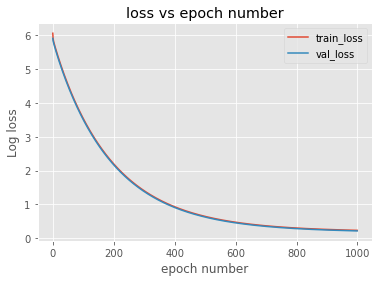

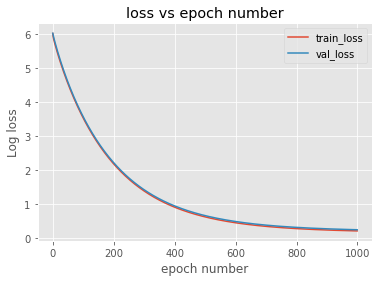

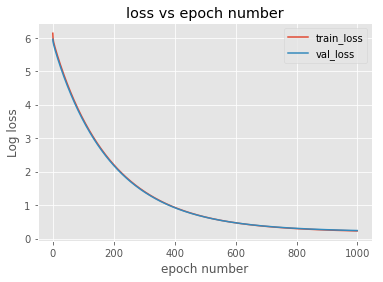

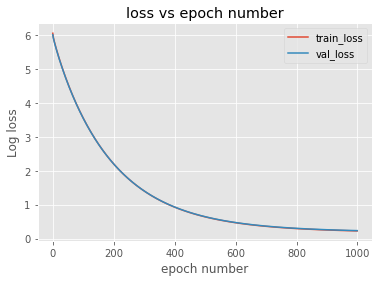

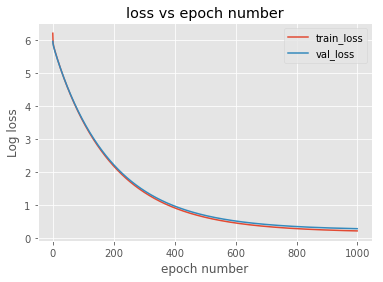

In [13]:
# Plot learning curves for validation and training data during learning
for history in train_results['history']:
    show_loss(history)

# EVALUATION ON TEST DATASET

In [14]:
# Overall Accuracy, Precision, Recall and F1 score for test dataset for each model from cross validation

test_results = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1_score': []}
confusion_matrixes = []
for model in train_results['models']:
    predicted = model.predict(x_test)
    
    predicted = np.asarray([np.round(j[0]) for j in predicted])
    actual = np.asarray([j[0] for j in y_test])
        
    TP = np.count_nonzero(predicted * actual)
    TN = np.count_nonzero((predicted - 1) * (actual - 1))
    FP = np.count_nonzero(predicted * (actual - 1))
    FN = np.count_nonzero((predicted - 1) * actual)

    confusion_matrix_dict = {'actual 1': [TP, FN], 'actual 0': [FP, TN]}
    confusion_matrix = pd.DataFrame(data=confusion_matrix_dict, columns =['actual 1', 'actual 0'], index=['predicted 1', 'predicted 0'])
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = metrics.accuracy_score(actual, predicted)
    
    test_results['Accuracy'].append(accuracy)
    test_results['Precision'].append(precision)
    test_results['Recall'].append(recall)
    test_results['F1_score'].append(f1)
    confusion_matrixes.append(confusion_matrix)
    
columns = ['Accuracy', 'Precision', 'Recall', 'F1_score']
indexes = ['K-fold {}'.format(i) for i in range(1, N_SPLITS+1)]
results_dataframe = pd.DataFrame(data=test_results, columns=columns, index=indexes)
results_dataframe

,Accuracy,Precision,Recall,F1_score
K-fold 1,0.986166,0.105626,0.910891,0.189300
K-fold 2,0.982954,0.086502,0.900990,0.157849
K-fold 3,0.983550,0.090196,0.910891,0.164139
K-fold 4,0.983972,0.092369,0.910891,0.167730
K-fold 5,0.985815,0.102362,0.900990,0.183838


/home/maciejpesko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


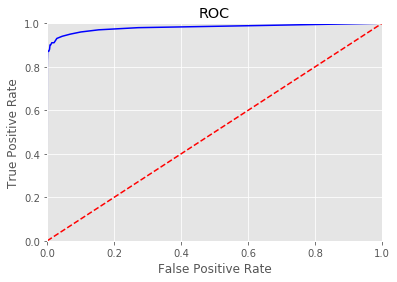

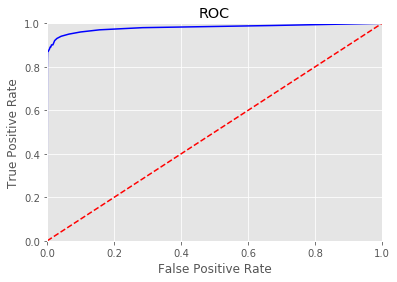

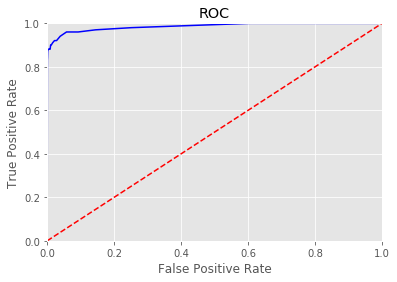

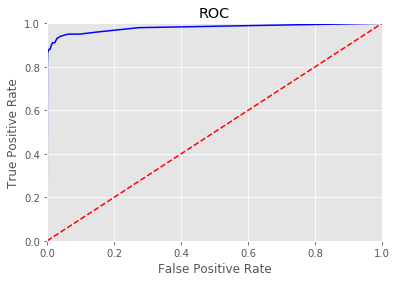

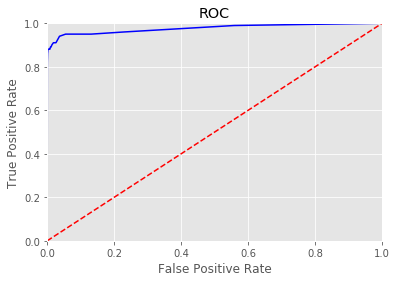

In [15]:
for model in train_results['models']:
    TPR_array = []
    FPR_array = []
    for i in range(-50,50,5):
        predicted = model.predict(x_test)
        predicted = np.asarray([np.round(j[0]+i/100) for j in predicted])
        actual = np.asarray([j[0] for j in y_test])

        TP = np.count_nonzero(np.multiply(predicted, actual))
        TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
        FP = np.count_nonzero(np.multiply(predicted, actual - 1))
        FN = np.count_nonzero(np.multiply(predicted - 1, actual))

        TPR_array.append(TP / (TP+FN))
        FPR_array.append(FP / (FP+TN))

    plot_ROC(TPR_array, FPR_array)

In [16]:
# Confusion matrixes for each valdation
for matrix in confusion_matrixes:
    display(matrix)


,actual 1,actual 0
predicted 1,92,779
predicted 0,9,56082


,actual 1,actual 0
predicted 1,91,961
predicted 0,10,55900


,actual 1,actual 0
predicted 1,92,928
predicted 0,9,55933


,actual 1,actual 0
predicted 1,92,904
predicted 0,9,55957


,actual 1,actual 0
predicted 1,91,798
predicted 0,10,56063
